In [ ]:
import re
import random
import numpy as np
from scipy.special import softmax
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler

import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
!pip install datasets
!pip install optuna
from datasets import Dataset
from sklearn.metrics import mean_squared_error
from transformers import EarlyStoppingCallback
import os
from scipy.special import expit
os.environ["WANDB_DISABLED"] = "true"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
usecols = ['id', 'regulationMark', 'hp', 'name', 'types', 'subtypes', 'evolvesFrom', 'evolvesTo', 'weaknesses', 'convertedRetreatCost', 'resistances', 'cleaned_attacks', 'cleaned_abilities', 'cleaned_rules', 'tournamentYear']

pokemon_2021 = pd.read_csv('/content/drive/MyDrive/266/project/standard_2021_pokemon_power_level.csv')
pokemon_2022 = pd.read_csv('/content/drive/MyDrive/266/project/standard_2022_pokemon_power_level.csv')
pokemon_2023 = pd.read_csv('/content/drive/MyDrive/266/project/standard_2023_pokemon_power_level.csv')
trainer_2021 = pd.read_csv('/content/drive/MyDrive/266/project/standard_2021_trainer_power_level.csv')
trainer_2022 = pd.read_csv('/content/drive/MyDrive/266/project/standard_2022_trainer_power_level.csv')
trainer_2023 = pd.read_csv('/content/drive/MyDrive/266/project/standard_2023_trainer_power_level.csv')


In [ ]:
def print_top_10_predictions(predicted_values, actual_values, test_df):
    names = test_df['name'].values

    top_10_predicted_indices = np.argsort(predicted_values)[-10:][::-1]

    top_10_actual_indices = np.argsort(actual_values)[-10:][::-1]

    print("Top 10 Highest Predicted Values:")
    print("-" * 50)
    for i in top_10_predicted_indices:
        print(f"Name: {names[i]}, Predicted: {predicted_values[i]:.4f}, Actual: {actual_values[i]:.4f}")

    print("\nTop 10 Highest Actual Values:")
    print("-" * 50)
    for i in top_10_actual_indices:
        print(f"Name: {names[i]}, Actual: {actual_values[i]:.4f}, Predicted: {predicted_values[i]:.4f}")


In [ ]:
from transformers import (
        BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
    )

def train_and_evaluate_bert_model(train_df, test_df, usecols, model_save_path, num_epochs=20, batch_size=8):
    train_df = train_df[usecols + ['power_level']]
    test_df = test_df[usecols + ['power_level']]

    def combine_features(row):
        return ' '.join(row.values.astype(str))

    train_df['text'] = train_df[usecols].apply(combine_features, axis=1)
    test_df['text'] = test_df[usecols].apply(combine_features, axis=1)

    train_dataset = Dataset.from_pandas(train_df[['text', 'power_level']])
    test_dataset = Dataset.from_pandas(test_df[['text', 'power_level']])

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def preprocess_function(examples):
        return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=512)

    train_dataset = train_dataset.map(preprocess_function, batched=True)
    test_dataset = test_dataset.map(preprocess_function, batched=True)

    train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'power_level'])
    test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'power_level'])

    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)  # Regression

    def add_labels_to_dataset(dataset):
        dataset = dataset.map(lambda x: {'labels': x['power_level']}, batched=True)
        return dataset

    train_dataset = add_labels_to_dataset(train_dataset)
    test_dataset = add_labels_to_dataset(test_dataset)

    class CustomTrainer(Trainer):
        def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
          labels = inputs.get("labels")
          outputs = model(**inputs)
          logits = outputs.get("logits").squeeze()

          predictions = torch.sigmoid(logits)

          abs_error = torch.abs(predictions - labels)
          weights = torch.where(abs_error < 0.1, 1.0, 2.0).to(predictions.device)

          delta = 1.0
          loss = torch.where(abs_error <= delta, 0.5 * (abs_error ** 2), delta * (abs_error - 0.5 * delta))
          loss = loss * weights
          loss = loss.mean()

          return (loss, outputs) if return_outputs else loss

    training_args = TrainingArguments(
        output_dir='./outputResults',
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        learning_rate=3e-5,  # Lower learning rate for better convergence
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        report_to=None,
        metric_for_best_model="mae",
        greater_is_better=False,
    )

    def compute_metrics(eval_pred):
      logits, labels = eval_pred
      predictions = torch.sigmoid(torch.tensor(logits.squeeze())).numpy()
      mae = mean_absolute_error(labels, predictions)
      return {"mae": mae}

    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    )

    trainer.train()
    eval_results = trainer.evaluate()
    print(eval_results)

    predictions = trainer.predict(test_dataset)
    predicted_values = torch.sigmoid(torch.tensor(predictions.predictions.squeeze())).numpy()
    predicted_values = np.clip(predicted_values, 0, 1)
    actual_values = predictions.label_ids

    print_top_10_predictions(predicted_values, actual_values, test_df)

    def plot_predictions(predictions, actual_values):
        plt.figure(figsize=(10, 6))
        plt.scatter(actual_values, predictions, alpha=0.5, c='blue', label='Predictions')
        plt.xlabel('Actual Power Level')
        plt.ylabel('Predicted Power Level')
        plt.title('Predicted vs. Actual Power Levels')
        plt.legend()
        plt.show()

    plot_predictions(predicted_values, actual_values)

    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)

    model.save_pretrained(model_save_path)

    tokenizer.save_pretrained(model_save_path)


<ipython-input-9-bf2501ee3d0e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df[usecols].apply(combine_features, axis=1)
<ipython-input-9-bf2501ee3d0e>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text'] = test_df[usecols].apply(combine_features, axis=1)


Map:   0%|          | 0/2313 [00:00<?, ? examples/s]

Map:   0%|          | 0/1454 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2313 [00:00<?, ? examples/s]

Map:   0%|          | 0/1454 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-9-bf2501ee3d0e>:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Epoch,Training Loss,Validation Loss,Mae
1,0.000400,0.000291,0.017681
2,0.000100,0.000222,0.009364
3,0.000100,0.000216,0.007390
4,0.000900,0.000212,0.007621
5,0.001000,0.000204,0.006511
6,0.000700,0.000213,0.011755
7,0.000100,0.000169,0.007452
8,0.000300,0.000205,0.005560
9,0.000100,0.000153,0.005758
10,0.000100,0.000175,0.005358


{'eval_loss': 0.00018551945686340332, 'eval_mae': 0.00444794213399291, 'eval_runtime': 40.2383, 'eval_samples_per_second': 36.135, 'eval_steps_per_second': 4.523, 'epoch': 14.0}
Top 10 Highest Predicted Values:
--------------------------------------------------
Name: Archeops, Predicted: 0.0452, Actual: 0.1490
Name: Lugia VSTAR, Predicted: 0.0315, Actual: 0.1125
Name: Arceus VSTAR, Predicted: 0.0304, Actual: 0.0928
Name: Lumineon V, Predicted: 0.0282, Actual: 0.1267
Name: Lugia V, Predicted: 0.0256, Actual: 0.1453
Name: Magnezone, Predicted: 0.0211, Actual: 0.0006
Name: Pidgeot ex, Predicted: 0.0135, Actual: 0.0165
Name: Radiant Eevee, Predicted: 0.0111, Actual: 0.0000
Name: Dragonite VSTAR, Predicted: 0.0111, Actual: 0.0000
Name: Pidgeot V, Predicted: 0.0098, Actual: 0.0075

Top 10 Highest Actual Values:
--------------------------------------------------
Name: Comfey, Actual: 0.2870, Predicted: 0.0058
Name: Archeops, Actual: 0.1490, Predicted: 0.0452
Name: Lugia V, Actual: 0.1453, Pre

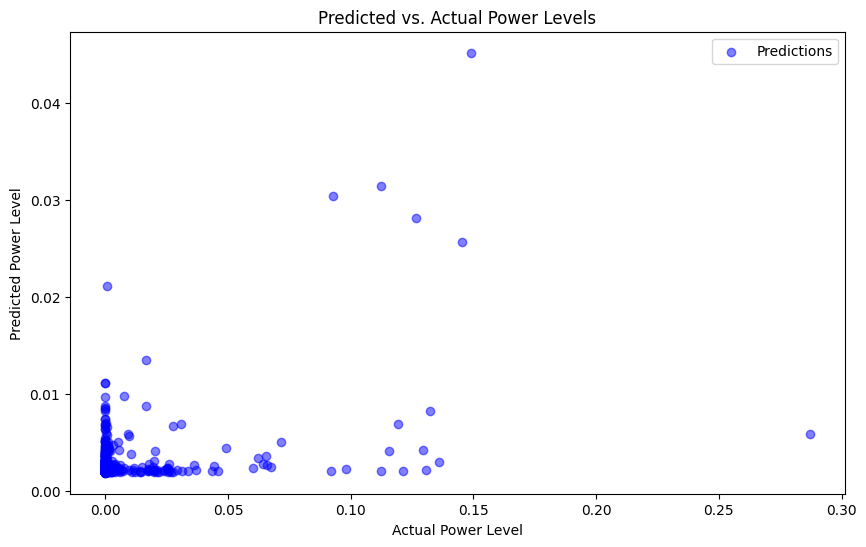

In [ ]:
# Pokemon Bert Model 2
model_save_path = '/content/drive/MyDrive/266/project/pokemonModel2'

pokemon_concat = pd.concat([pokemon_2021, pokemon_2022], ignore_index=True)

train_and_evaluate_bert_model(pokemon_concat, pokemon_2023, usecols, model_save_path)

<ipython-input-9-bf2501ee3d0e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df[usecols].apply(combine_features, axis=1)
<ipython-input-9-bf2501ee3d0e>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text'] = test_df[usecols].apply(combine_features, axis=1)


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-9-bf2501ee3d0e>:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Epoch,Training Loss,Validation Loss,Mae
1,0.105200,0.059027,0.236646
2,0.014600,0.011025,0.096321
3,0.011400,0.008953,0.077712
4,0.010100,0.008790,0.067274
5,0.011300,0.009258,0.070261
6,0.010200,0.009341,0.067278
7,0.015300,0.009896,0.069795


{'eval_loss': 0.008789840154349804, 'eval_mae': 0.06727391481399536, 'eval_runtime': 6.168, 'eval_samples_per_second': 35.992, 'eval_steps_per_second': 4.54, 'epoch': 7.0}
Top 10 Highest Predicted Values:
--------------------------------------------------
Name: Switch, Predicted: 0.1732, Actual: 0.0936
Name: Superior Energy Retrieval, Predicted: 0.0775, Actual: 0.0314
Name: Ultra Ball, Predicted: 0.0677, Actual: 0.6744
Name: Temple of Sinnoh, Predicted: 0.0660, Actual: 0.0383
Name: Crushing Hammer, Predicted: 0.0659, Actual: 0.0022
Name: Gloria, Predicted: 0.0642, Actual: 0.0000
Name: Battle VIP Pass, Predicted: 0.0641, Actual: 0.6656
Name: Nest Ball, Predicted: 0.0636, Actual: 0.5594
Name: Grabber, Predicted: 0.0633, Actual: 0.0039
Name: Jubilife Village, Predicted: 0.0633, Actual: 0.0000

Top 10 Highest Actual Values:
--------------------------------------------------
Name: Ultra Ball, Actual: 0.6744, Predicted: 0.0677
Name: Battle VIP Pass, Actual: 0.6656, Predicted: 0.0641
Name: Ne

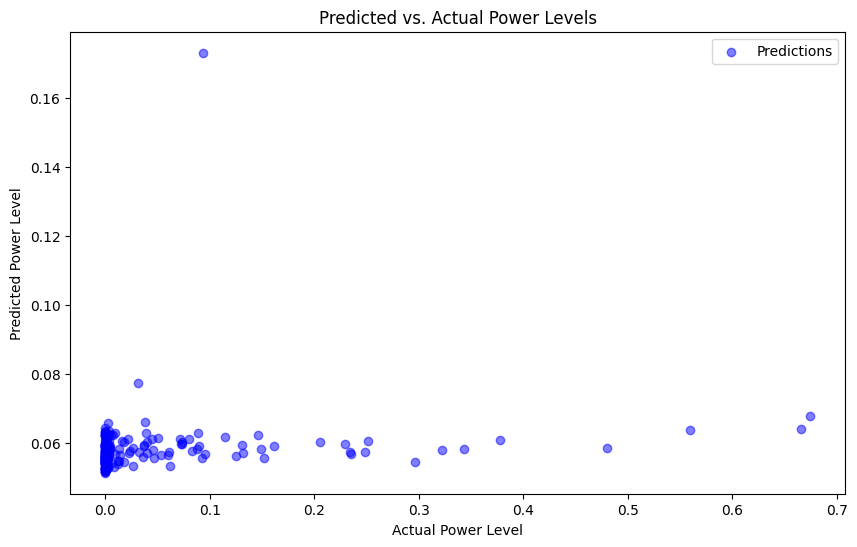

In [ ]:
# Trainer Bert Model 2
model_save_path = '/content/drive/MyDrive/266/project/trainerModel2'

trainer_concat = pd.concat([trainer_2021, trainer_2022], ignore_index=True)

train_and_evaluate_bert_model(trainer_concat, trainer_2023, usecols, model_save_path)

In [ ]:
from transformers import (
    RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
)

def train_and_evaluate_roberta_model(train_df, test_df, usecols, model_save_path, num_epochs=20, batch_size=8):
    train_df = train_df[usecols + ['power_level']]
    test_df = test_df[usecols + ['power_level']]

    def combine_features(row):
        return ' '.join(row.values.astype(str))

    train_df['text'] = train_df[usecols].apply(combine_features, axis=1)
    test_df['text'] = test_df[usecols].apply(combine_features, axis=1)

    train_dataset = Dataset.from_pandas(train_df[['text', 'power_level']])
    test_dataset = Dataset.from_pandas(test_df[['text', 'power_level']])

    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

    def preprocess_function(examples):
        return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=512)

    train_dataset = train_dataset.map(preprocess_function, batched=True)
    test_dataset = test_dataset.map(preprocess_function, batched=True)

    train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'power_level'])
    test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'power_level'])

    model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=1)

    def add_labels_to_dataset(dataset):
        dataset = dataset.map(lambda x: {'labels': x['power_level']}, batched=True)
        return dataset

    train_dataset = add_labels_to_dataset(train_dataset)
    test_dataset = add_labels_to_dataset(test_dataset)

    class CustomTrainer(Trainer):
        def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
          labels = inputs.get("labels")
          outputs = model(**inputs)
          logits = outputs.get("logits").squeeze()
          predictions = torch.sigmoid(logits)
          abs_error = torch.abs(predictions - labels)
          weights = torch.where(abs_error < 0.1, 1.0, 2.0).to(predictions.device)
          delta = 1.0
          loss = torch.where(abs_error <= delta, 0.5 * (abs_error ** 2), delta * (abs_error - 0.5 * delta))
          loss = loss * weights
          loss = loss.mean()
          return (loss, outputs) if return_outputs else loss

    training_args = TrainingArguments(
        output_dir='./outputResults',
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        learning_rate=2e-5,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        report_to=None,
        metric_for_best_model="mae",
        greater_is_better=False,
    )

    def compute_metrics(eval_pred):
      logits, labels = eval_pred
      predictions = torch.sigmoid(torch.tensor(logits.squeeze())).numpy()
      mae = mean_absolute_error(labels, predictions)
      return {"mae": mae}

    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    )

    trainer.train()
    eval_results = trainer.evaluate()
    print(eval_results)

    predictions = trainer.predict(test_dataset)
    predicted_values = torch.sigmoid(torch.tensor(predictions.predictions.squeeze())).numpy()
    predicted_values = np.clip(predicted_values, 0, 1)
    actual_values = predictions.label_ids

    print_top_10_predictions(predicted_values, actual_values, test_df)

    def plot_predictions(predictions, actual_values):
        plt.figure(figsize=(10, 6))
        plt.scatter(actual_values, predictions, alpha=0.5, c='blue', label='Predictions')
        plt.xlabel('Actual Power Level')
        plt.ylabel('Predicted Power Level')
        plt.title('Predicted vs. Actual Power Levels')
        plt.legend()
        plt.show()

    plot_predictions(predicted_values, actual_values)

    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)

    model.save_pretrained(model_save_path)
    tokenizer.save_pretrained(model_save_path)


<ipython-input-4-7db3d88512a4>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df[usecols].apply(combine_features, axis=1)
<ipython-input-4-7db3d88512a4>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text'] = test_df[usecols].apply(combine_features, axis=1)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/2313 [00:00<?, ? examples/s]

Map:   0%|          | 0/1454 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2313 [00:00<?, ? examples/s]

Map:   0%|          | 0/1454 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-4-7db3d88512a4>:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Epoch,Training Loss,Validation Loss,Mae
1,0.000300,0.000239,0.012181
2,0.000100,0.000216,0.007632
3,0.000100,0.000214,0.006431
4,0.000800,0.000200,0.007703
5,0.000900,0.000210,0.006178
6,0.000800,0.000205,0.009631
7,0.000100,0.000212,0.005529
8,0.000300,0.000208,0.005487
9,0.000200,0.000213,0.005171
10,0.000100,0.000194,0.005800


{'eval_loss': 0.0001991220924537629, 'eval_mae': 0.004590925294905901, 'eval_runtime': 36.4808, 'eval_samples_per_second': 39.857, 'eval_steps_per_second': 4.989, 'epoch': 15.0}
Top 10 Highest Predicted Values:
--------------------------------------------------
Name: Lugia VSTAR, Predicted: 0.0216, Actual: 0.1125
Name: Arceus VSTAR, Predicted: 0.0164, Actual: 0.0928
Name: Genesect V, Predicted: 0.0155, Actual: 0.1322
Name: Pidgeot ex, Predicted: 0.0148, Actual: 0.0165
Name: Mew ex, Predicted: 0.0140, Actual: 0.0095
Name: Lumineon V, Predicted: 0.0116, Actual: 0.1267
Name: Archeops, Predicted: 0.0113, Actual: 0.1490
Name: Magnezone, Predicted: 0.0097, Actual: 0.0006
Name: Squawkabilly ex, Predicted: 0.0093, Actual: 0.0165
Name: Mew, Predicted: 0.0090, Actual: 0.0000

Top 10 Highest Actual Values:
--------------------------------------------------
Name: Comfey, Actual: 0.2870, Predicted: 0.0084
Name: Archeops, Actual: 0.1490, Predicted: 0.0113
Name: Lugia V, Actual: 0.1453, Predicted: 0.

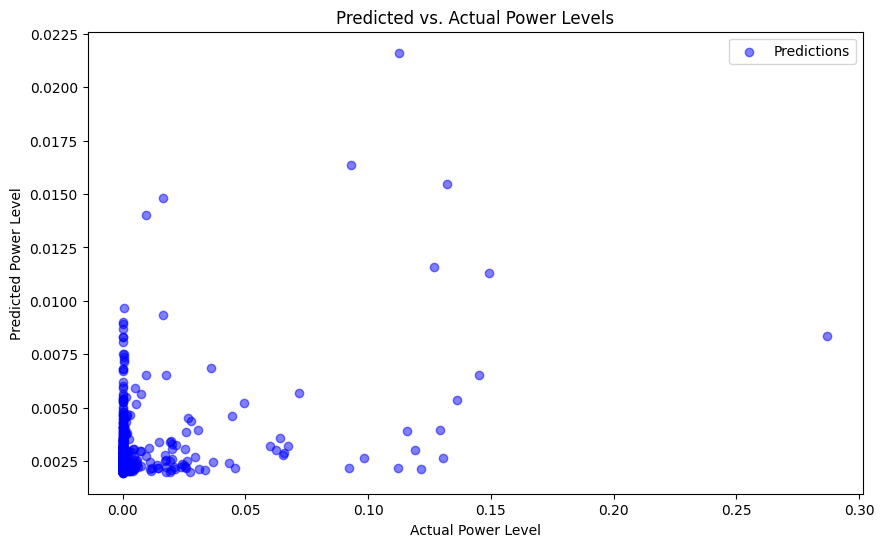

In [ ]:
# Pokemon Roberta Model
model_save_path = '/content/drive/MyDrive/266/project/pokemonRoberta'

pokemon_concat = pd.concat([pokemon_2021, pokemon_2022], ignore_index=True)

train_and_evaluate_roberta_model(pokemon_concat, pokemon_2023, usecols, model_save_path)

<ipython-input-17-2bd684f5eb01>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df[usecols].apply(combine_features, axis=1)
<ipython-input-17-2bd684f5eb01>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text'] = test_df[usecols].apply(combine_features, axis=1)
<ipython-input-17-2bd684f5eb01>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Map:   0%|          | 0/278 [00:00<?, ? examples/s]

Map:   0%|          | 0/192 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/278 [00:00<?, ? examples/s]

Map:   0%|          | 0/192 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-17-2bd684f5eb01>:88: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Epoch,Training Loss,Validation Loss,Mae
1,0.017100,0.005822,0.055262
2,0.011800,0.005878,0.047338
3,0.005900,0.005868,0.044631
4,0.010100,0.006768,0.033550
5,0.011100,0.006215,0.036042
6,0.007400,0.005454,0.042914
7,0.008600,0.006387,0.039247
8,0.004800,0.004147,0.043905
9,0.010500,0.004145,0.043571
10,0.010200,0.006922,0.058518


{'eval_loss': 0.0036433010827749968, 'eval_mae': 0.029052024707198143, 'eval_runtime': 5.0136, 'eval_samples_per_second': 38.296, 'eval_steps_per_second': 4.787, 'epoch': 20.0}
Top 10 Highest Predicted Values:
--------------------------------------------------
Name: Boss's Orders, Predicted: 0.4637, Actual: 0.4798
Name: Battle VIP Pass, Predicted: 0.3217, Actual: 0.6656
Name: Switch, Predicted: 0.2045, Actual: 0.0936
Name: Professor's Research, Predicted: 0.1853, Actual: 0.3436
Name: Escape Rope, Predicted: 0.1678, Actual: 0.3773
Name: Marnie's Pride, Predicted: 0.1140, Actual: 0.0000
Name: Switch Cart, Predicted: 0.0956, Actual: 0.2966
Name: Ultra Ball, Predicted: 0.0947, Actual: 0.6744
Name: Cram-o-matic, Predicted: 0.0855, Actual: 0.1307
Name: Path to the Peak, Predicted: 0.0628, Actual: 0.2059

Top 10 Highest Actual Values:
--------------------------------------------------
Name: Ultra Ball, Actual: 0.6744, Predicted: 0.0947
Name: Battle VIP Pass, Actual: 0.6656, Predicted: 0.3217


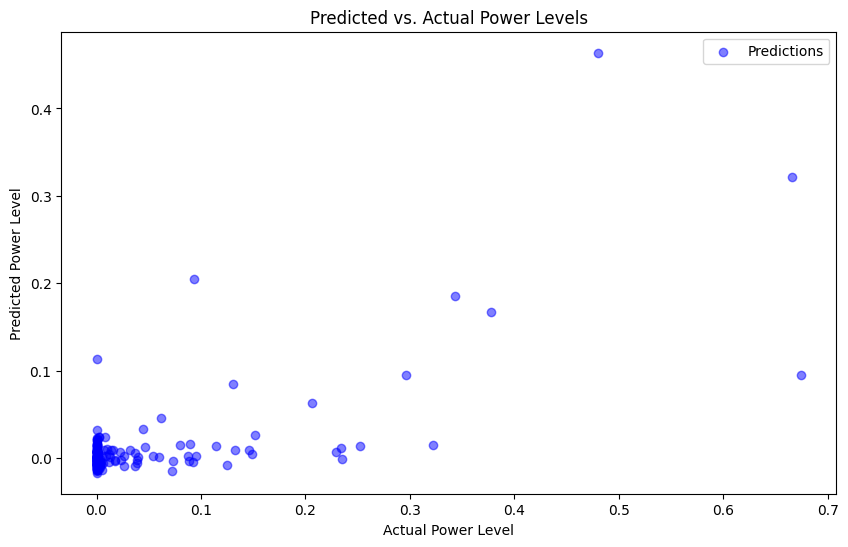

In [ ]:
# Trainer Roberta Model
model_save_path = '/content/drive/MyDrive/266/project/trainerRoberta'

trainer_concat = pd.concat([trainer_2021, trainer_2022], ignore_index=True)

train_and_evaluate_roberta_model(trainer_concat, trainer_2023, usecols, model_save_path)

<ipython-input-12-7d1c14f96c66>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df[usecols].apply(combine_features, axis=1)
<ipython-input-12-7d1c14f96c66>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text'] = test_df[usecols].apply(combine_features, axis=1)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-12-7d1c14f96c66>:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Epoch,Training Loss,Validation Loss,Mae
1,0.153500,0.101344,0.311968
2,0.007100,0.009347,0.052662
3,0.011900,0.009209,0.057406
4,0.009800,0.008745,0.068914
5,0.013000,0.008502,0.059751


{'eval_loss': 0.009347454644739628, 'eval_mae': 0.05266173183917999, 'eval_runtime': 5.7221, 'eval_samples_per_second': 38.797, 'eval_steps_per_second': 4.893, 'epoch': 5.0}
Top 10 Highest Predicted Values:
--------------------------------------------------
Name: Great Ball, Predicted: 0.0526, Actual: 0.0096
Name: Switch, Predicted: 0.0490, Actual: 0.0936
Name: Gapejaw Bog, Predicted: 0.0459, Actual: 0.0006
Name: Shopping Center, Predicted: 0.0429, Actual: 0.0000
Name: Temple of Sinnoh, Predicted: 0.0408, Actual: 0.0383
Name: Skaters' Park, Predicted: 0.0406, Actual: 0.0018
Name: Crushing Hammer, Predicted: 0.0405, Actual: 0.0022
Name: Phoebe, Predicted: 0.0399, Actual: 0.0000
Name: Crystal Cave, Predicted: 0.0398, Actual: 0.0053
Name: Lake Acuity, Predicted: 0.0396, Actual: 0.0000

Top 10 Highest Actual Values:
--------------------------------------------------
Name: Ultra Ball, Actual: 0.6744, Predicted: 0.0331
Name: Battle VIP Pass, Actual: 0.6656, Predicted: 0.0325
Name: Nest Ball,

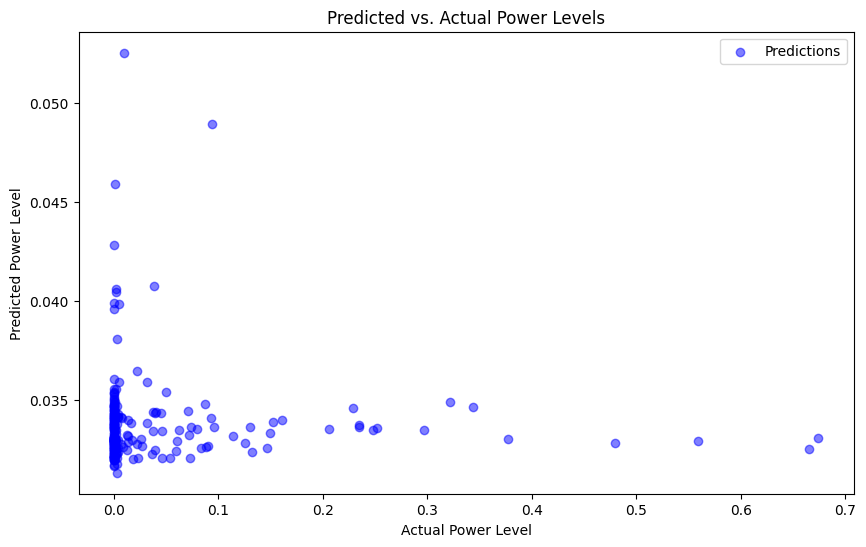

In [ ]:
# Trainer Roberta Model 2
model_save_path = '/content/drive/MyDrive/266/project/trainerRoberta2'

trainer_concat = pd.concat([trainer_2021, trainer_2022], ignore_index=True)

train_and_evaluate_roberta_model(trainer_concat, trainer_2023, usecols, model_save_path)

In [ ]:
from torch import nn
from transformers import (
    RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
)

class RoBERTaWithDenseLayers(RobertaForSequenceClassification):
    def __init__(self, config):
        super(RoBERTaWithDenseLayers, self).__init__(config)
        self.dense1 = nn.Linear(config.hidden_size, 512)
        self.dense2 = nn.Linear(512, 128)
        self.output_layer = nn.Linear(128, 1)
        self.dense1.weight.data.normal_(mean=0.0, std=config.initializer_range)
        self.dense2.weight.data.normal_(mean=0.0, std=config.initializer_range)
        self.output_layer.weight.data.normal_(mean=0.0, std=config.initializer_range)

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None, **kwargs):
        roberta_output = self.roberta(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, **kwargs)
        hidden_state = roberta_output[0]
        pooled_output = hidden_state[:, 0]
        x = self.dense1(pooled_output)
        x = torch.relu(x)
        x = self.dense2(x)
        x = torch.relu(x)
        logits = self.output_layer(x)
        loss = None
        if labels is not None:
            loss_fct = nn.MSELoss()
            loss = loss_fct(logits.squeeze(), labels)
        return (loss, logits) if loss is not None else logits

def train_and_evaluate_roberta_dense_model(train_df, test_df, usecols, model_save_path, num_epochs=20, batch_size=8):
    train_df = train_df[usecols + ['power_level']]
    test_df = test_df[usecols + ['power_level']]

    def combine_features(row):
        return ' '.join(row.values.astype(str))

    train_df['text'] = train_df[usecols].apply(combine_features, axis=1)
    test_df['text'] = test_df[usecols].apply(combine_features, axis=1)

    train_dataset = Dataset.from_pandas(train_df[['text', 'power_level']])
    test_dataset = Dataset.from_pandas(test_df[['text', 'power_level']])

    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

    def preprocess_function(examples):
        return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=512)

    train_dataset = train_dataset.map(preprocess_function, batched=True)
    test_dataset = test_dataset.map(preprocess_function, batched=True)

    train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'power_level'])
    test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'power_level'])

    model = RoBERTaWithDenseLayers.from_pretrained('roberta-base', num_labels=1)

    def add_labels_to_dataset(dataset):
        return dataset.map(lambda x: {'labels': x['power_level']}, batched=True)

    train_dataset = add_labels_to_dataset(train_dataset)
    test_dataset = add_labels_to_dataset(test_dataset)

    class CustomTrainer(Trainer):
        def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
            labels = inputs.get("labels")
            outputs = model(**inputs, output_attentions=True)
            logits = outputs[1].squeeze()
            predictions = torch.sigmoid(logits)
            abs_error = torch.abs(predictions - labels)
            weights = torch.where(abs_error < 0.1, 1.0, 2.0).to(predictions.device)
            delta = 1.0
            loss = torch.where(abs_error <= delta, 0.5 * (abs_error ** 2), delta * (abs_error - 0.5 * delta))
            loss = loss * weights
            loss = loss.mean()
            return (loss, outputs) if return_outputs else loss

    training_args = TrainingArguments(
        output_dir='./outputResults',
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        learning_rate=3e-5,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        report_to=None,
    )

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = torch.sigmoid(torch.tensor(logits.squeeze())).numpy()
        mae = mean_absolute_error(labels, predictions)
        return {"mae": mae}

    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    eval_results = trainer.evaluate()
    print(eval_results)

    predictions = trainer.predict(test_dataset)
    predicted_values = torch.sigmoid(torch.tensor(predictions.predictions.squeeze())).numpy()
    predicted_values = np.clip(predicted_values, 0, 1)
    actual_values = predictions.label_ids

    print_top_10_predictions(predicted_values, actual_values, test_df)

    def plot_predictions(predictions, actual_values):
        plt.figure(figsize=(10, 6))
        plt.scatter(actual_values, predictions, alpha=0.5, c='blue', label='Predictions')
        plt.xlabel('Actual Power Level')
        plt.ylabel('Predicted Power Level')
        plt.title('Predicted vs. Actual Power Levels')
        plt.legend()
        plt.show()

    plot_predictions(predicted_values, actual_values)

    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)
    model.save_pretrained(model_save_path)
    tokenizer.save_pretrained(model_save_path)


<ipython-input-11-e67642ba6aca>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df[usecols].apply(combine_features, axis=1)
<ipython-input-11-e67642ba6aca>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text'] = test_df[usecols].apply(combine_features, axis=1)


Map:   0%|          | 0/2313 [00:00<?, ? examples/s]

Map:   0%|          | 0/1454 [00:00<?, ? examples/s]

Some weights of RoBERTaWithDenseLayers were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'dense1.bias', 'dense1.weight', 'dense2.bias', 'dense2.weight', 'output_layer.bias', 'output_layer.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2313 [00:00<?, ? examples/s]

Map:   0%|          | 0/1454 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-11-e67642ba6aca>:127: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Epoch,Training Loss,Validation Loss,Mae
1,0.003000,0.002461,0.069478
2,0.000200,0.000262,0.015221
3,0.000100,0.000223,0.009522
4,0.000900,0.000217,0.007769
5,0.001000,0.000215,0.007016
6,0.000900,0.000215,0.006656
7,0.000100,0.000215,0.006488
8,0.000300,0.000215,0.006323
9,0.000200,0.000214,0.006189
10,0.000100,0.000214,0.006096


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction

{'eval_loss': 0.000174525601323694, 'eval_mae': 0.007832488976418972, 'eval_runtime': 43.8331, 'eval_samples_per_second': 33.171, 'eval_steps_per_second': 4.152, 'epoch': 20.0}
Top 10 Highest Predicted Values:
--------------------------------------------------
Name: Mew, Predicted: 0.0677, Actual: 0.0000
Name: Comfey, Predicted: 0.0665, Actual: 0.2870
Name: Arceus VSTAR, Predicted: 0.0643, Actual: 0.0928
Name: Pidgeot ex, Predicted: 0.0616, Actual: 0.0165
Name: Magnezone, Predicted: 0.0612, Actual: 0.0006
Name: Lumineon V, Predicted: 0.0611, Actual: 0.1267
Name: Kricketune V, Predicted: 0.0592, Actual: 0.0004
Name: Genesect V, Predicted: 0.0586, Actual: 0.1322
Name: Celebi, Predicted: 0.0567, Actual: 0.0000
Name: Gardevoir, Predicted: 0.0564, Actual: 0.0675

Top 10 Highest Actual Values:
--------------------------------------------------
Name: Comfey, Actual: 0.2870, Predicted: 0.0665
Name: Archeops, Actual: 0.1490, Predicted: 0.0492
Name: Lugia V, Actual: 0.1453, Predicted: 0.0212
Nam

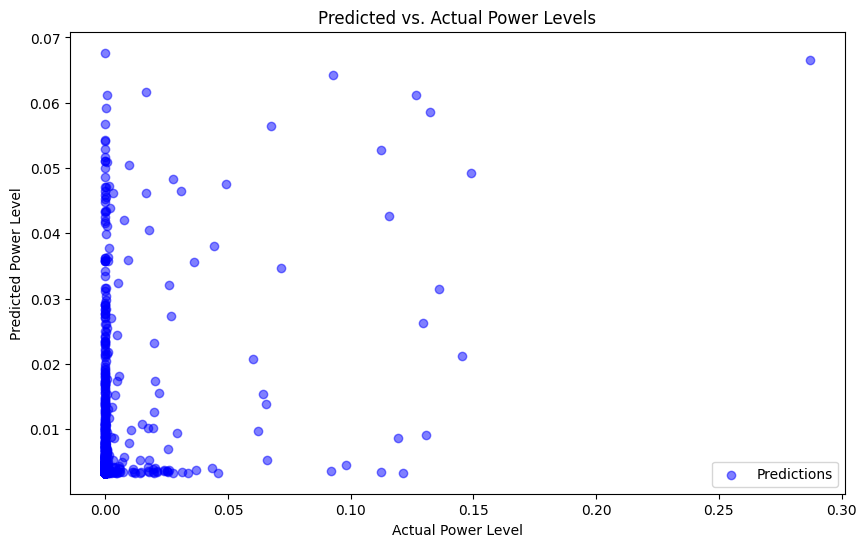

In [ ]:
# Pokemon Roberta Dense Model
model_save_path = '/content/drive/MyDrive/266/project/pokemonRobertaDense'

pokemon_concat = pd.concat([pokemon_2021, pokemon_2022], ignore_index=True)

train_and_evaluate_roberta_dense_model(pokemon_concat, pokemon_2023, usecols, model_save_path)

<ipython-input-11-8df063f7325b>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df[usecols].apply(combine_features, axis=1)
<ipython-input-11-8df063f7325b>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text'] = test_df[usecols].apply(combine_features, axis=1)


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

Some weights of RoBERTaWithDenseLayers were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'dense1.bias', 'dense1.weight', 'dense2.bias', 'dense2.weight', 'output_layer.bias', 'output_layer.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-11-8df063f7325b>:127: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Epoch,Training Loss,Validation Loss,Mae
1,0.211100,0.210196,0.451614
2,0.137000,0.122113,0.343130
3,0.078100,0.067729,0.254141
4,0.040300,0.033896,0.177181
5,0.022200,0.016883,0.117681
6,0.011900,0.009336,0.087204
7,0.023000,0.009077,0.079732
8,0.006900,0.009201,0.082551
9,0.018600,0.008891,0.072965
10,0.010300,0.008781,0.075697


{'eval_loss': 0.008400791324675083, 'eval_mae': 0.059489257633686066, 'eval_runtime': 5.8266, 'eval_samples_per_second': 38.101, 'eval_steps_per_second': 4.806, 'epoch': 20.0}
Top 10 Highest Predicted Values:
--------------------------------------------------
Name: Switch, Predicted: 0.4448, Actual: 0.0936
Name: Boss's Orders, Predicted: 0.3408, Actual: 0.4798
Name: Pokémon Catcher, Predicted: 0.1333, Actual: 0.0049
Name: Toy Catcher, Predicted: 0.1276, Actual: 0.0000
Name: Switch Cart, Predicted: 0.1113, Actual: 0.2966
Name: Capturing Aroma, Predicted: 0.1046, Actual: 0.1521
Name: Cross Switcher, Predicted: 0.1006, Actual: 0.0620
Name: Ultra Ball, Predicted: 0.0985, Actual: 0.6744
Name: Escape Rope, Predicted: 0.0909, Actual: 0.3773
Name: Lost City, Predicted: 0.0896, Actual: 0.0883

Top 10 Highest Actual Values:
--------------------------------------------------
Name: Ultra Ball, Actual: 0.6744, Predicted: 0.0985
Name: Battle VIP Pass, Actual: 0.6656, Predicted: 0.0450
Name: Nest Bal

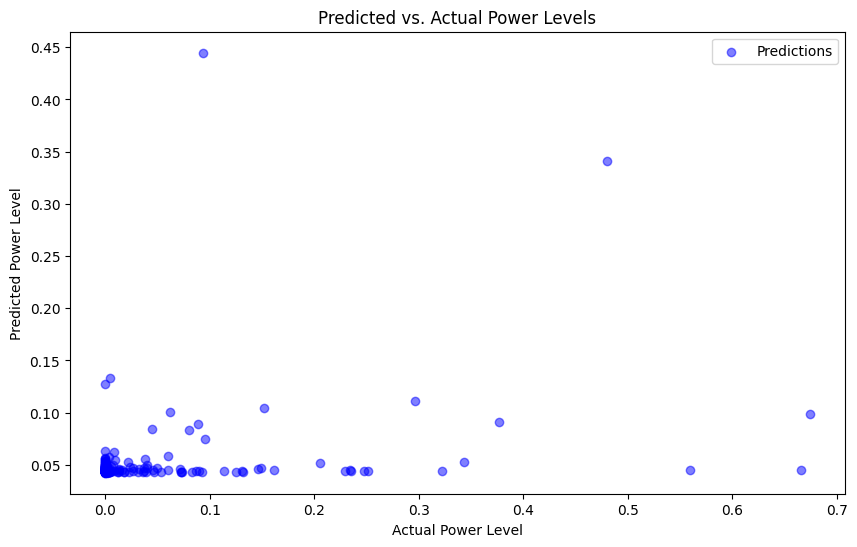

In [ ]:
# Trainer Roberta Dense Model
model_save_path = '/content/drive/MyDrive/266/project/trainerRobertaDense'

trainer_concat = pd.concat([trainer_2021, trainer_2022], ignore_index=True)

train_and_evaluate_roberta_dense_model(trainer_concat, trainer_2023, usecols, model_save_path)

In [ ]:
!pip install scikit-optimize

In [ ]:
from transformers import (
    RobertaTokenizer, RobertaForSequenceClassification, Trainer,
    TrainingArguments, EarlyStoppingCallback
)
from datasets import Dataset
from sklearn.metrics import mean_absolute_error
import numpy as np
import torch
import os
import matplotlib.pyplot as plt

def print_top_10_predictions(preds, labels, df):
    top_indices = np.argsort(np.abs(preds - labels))[:10]
    print(df.iloc[top_indices][['text']])
    print("Actual:", labels[top_indices])
    print("Predicted:", preds[top_indices])

def objective(params, train_df, test_df, usecols, model_save_path,
              num_epochs=20, batch_size=8, return_model=False):
    learning_rate, warmup_steps, weight_decay = params
    warmup_steps = int(warmup_steps)

    train_df = train_df[usecols + ['power_level']]
    test_df = test_df[usecols + ['power_level']]

    combine_features = lambda row: ' '.join(row.values.astype(str))
    train_df['text'] = train_df[usecols].apply(combine_features, axis=1)
    test_df['text'] = test_df[usecols].apply(combine_features, axis=1)

    train_dataset = Dataset.from_pandas(train_df[['text', 'power_level']])
    test_dataset = Dataset.from_pandas(test_df[['text', 'power_level']])

    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    def preprocess_function(examples):
        return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=512)
    train_dataset = train_dataset.map(preprocess_function, batched=True)
    test_dataset = test_dataset.map(preprocess_function, batched=True)

    train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'power_level'])
    test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'power_level'])

    model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=1)

    add_labels = lambda dataset: dataset.map(lambda x: {'labels': x['power_level']}, batched=True)
    train_dataset = add_labels(train_dataset)
    test_dataset = add_labels(test_dataset)

    class CustomTrainer(Trainer):
        def compute_loss(self, model, inputs, return_outputs=False):
            labels = inputs.get("labels")
            outputs = model(**inputs)
            logits = outputs.get("logits").squeeze()
            predictions = torch.sigmoid(logits)
            abs_error = torch.abs(predictions - labels)
            weights = torch.where(abs_error < 0.1, 1.0, 2.0).to(predictions.device)
            delta = 1.0
            loss = torch.where(abs_error <= delta,
                               0.5 * abs_error ** 2,
                               delta * (abs_error - 0.5 * delta))
            loss = (loss * weights).mean()
            return (loss, outputs) if return_outputs else loss

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = torch.sigmoid(torch.tensor(logits.squeeze())).numpy()
        return {"mae": mean_absolute_error(labels, preds)}

    training_args = TrainingArguments(
        output_dir='./outputResults',
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        learning_rate=learning_rate,
        warmup_steps=warmup_steps,
        weight_decay=weight_decay,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        save_total_limit=3,
        report_to=None,
        metric_for_best_model="mae",
        greater_is_better=False,
    )

    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    )

    trainer.train()

    eval_results = trainer.evaluate()
    print(eval_results)

    predictions = trainer.predict(test_dataset)
    predicted_values = torch.sigmoid(torch.tensor(predictions.predictions.squeeze())).numpy()
    predicted_values = np.clip(predicted_values, 0, 1)
    actual_values = predictions.label_ids

    print_top_10_predictions(predicted_values, actual_values, test_df)

    plt.figure(figsize=(10, 6))
    plt.scatter(actual_values, predicted_values, alpha=0.5, c='blue', label='Predictions')
    plt.xlabel('Actual Power Level')
    plt.ylabel('Predicted Power Level')
    plt.title('Predicted vs. Actual Power Levels')
    plt.legend()
    plt.show()

    if return_model:
        return trainer.model
    else:
        return eval_results['eval_mae']

def train_and_evaluate_roberta_tuned_model(train_df, test_df, usecols, model_save_path):
    from skopt import gp_minimize

    search_space = [
        (1e-6, 1e-4, 'log-uniform'),
        (500, 2000),
        (0.0, 0.1),
    ]

    result = gp_minimize(
        func=lambda params: objective(params, train_df, test_df, usecols, model_save_path),
        dimensions=search_space,
        n_calls=10,
        random_state=42
    )

    best_params = result.x
    print(f"Best hyperparameters: {best_params}")
    print(f"Best validation MAE: {result.fun}")

    print("Training final model with best parameters...")
    final_model = objective(best_params, train_df, test_df, usecols, model_save_path, return_model=True)

    os.makedirs(model_save_path, exist_ok=True)
    final_model.save_pretrained(model_save_path)
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    tokenizer.save_pretrained(model_save_path)

    return result


<ipython-input-5-7fa06a163cda>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df[usecols].apply(combine_features, axis=1)
<ipython-input-5-7fa06a163cda>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text'] = test_df[usecols].apply(combine_features, axis=1)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/2313 [00:00<?, ? examples/s]

Map:   0%|          | 0/1454 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2313 [00:00<?, ? examples/s]

Map:   0%|          | 0/1454 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-5-7fa06a163cda>:98: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Epoch,Training Loss,Validation Loss,Mae
1,0.000300,0.000226,0.010271
2,0.000100,0.000215,0.006807
3,0.000100,0.000214,0.005646
4,0.000900,0.000213,0.007235
5,0.001000,0.000212,0.005537
6,0.000900,0.000243,0.012688
7,0.000100,0.000215,0.005465
8,0.000300,0.000205,0.005046
9,0.000200,0.000215,0.004873
10,0.000100,0.000216,0.004627


Evaluation results: {'eval_loss': 0.00021584171918220818, 'eval_mae': 0.004573365673422813, 'eval_runtime': 37.8999, 'eval_samples_per_second': 38.364, 'eval_steps_per_second': 4.802, 'epoch': 14.0}
Top 10 Highest Predicted Values:
--------------------------------------------------
Name: Spiral Energy, Predicted: 0.0025, Actual: 0.0000
Name: Arceus VSTAR, Predicted: 0.0025, Actual: 0.0928
Name: Regigigas VSTAR, Predicted: 0.0025, Actual: 0.0000
Name: Dragonite VSTAR, Predicted: 0.0025, Actual: 0.0000
Name: Kecleon, Predicted: 0.0025, Actual: 0.0000
Name: Hisuian Lilligant VSTAR, Predicted: 0.0025, Actual: 0.0000
Name: Origin Forme Palkia VSTAR, Predicted: 0.0025, Actual: 0.0094
Name: Rotom VSTAR, Predicted: 0.0024, Actual: 0.0000
Name: Unown VSTAR, Predicted: 0.0024, Actual: 0.0000
Name: Darkrai VSTAR, Predicted: 0.0024, Actual: 0.0019

Top 10 Highest Actual Values:
--------------------------------------------------
Name: Comfey, Actual: 0.2870, Predicted: 0.0023
Name: Archeops, Actual

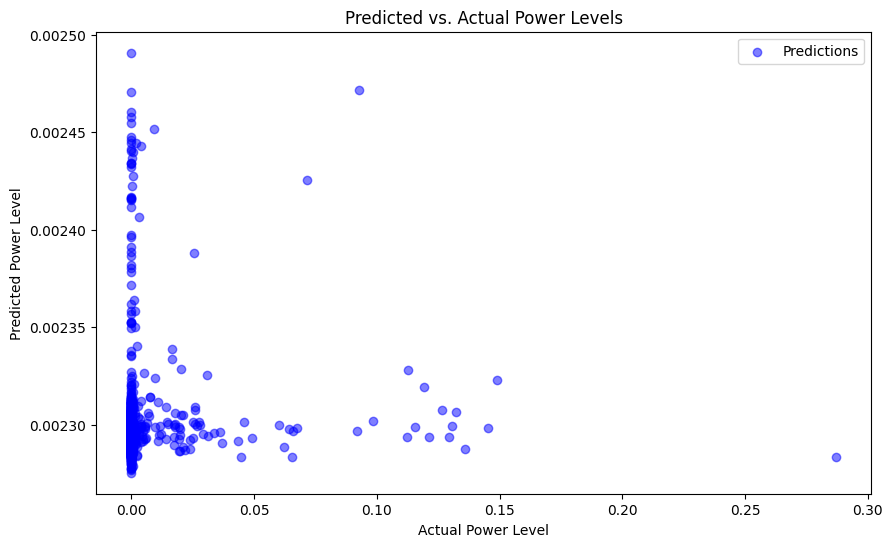

<ipython-input-5-7fa06a163cda>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df[usecols].apply(combine_features, axis=1)
<ipython-input-5-7fa06a163cda>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text'] = test_df[usecols].apply(combine_features, axis=1)


Map:   0%|          | 0/2313 [00:00<?, ? examples/s]

Map:   0%|          | 0/1454 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2313 [00:00<?, ? examples/s]

Map:   0%|          | 0/1454 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-5-7fa06a163cda>:98: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Epoch,Training Loss,Validation Loss,Mae
1,0.000400,0.000304,0.018550
2,0.000100,0.000225,0.009997
3,0.000100,0.000216,0.007509
4,0.000800,0.000217,0.009207
5,0.000900,0.000211,0.006460
6,0.000800,0.000220,0.011240
7,0.000100,0.000203,0.006271
8,0.000300,0.000192,0.006080
9,0.000200,0.000212,0.005428
10,0.000100,0.000174,0.007714


Evaluation results: {'eval_loss': 0.0001738422579364851, 'eval_mae': 0.004515024367719889, 'eval_runtime': 38.0365, 'eval_samples_per_second': 38.226, 'eval_steps_per_second': 4.785, 'epoch': 17.0}
Top 10 Highest Predicted Values:
--------------------------------------------------
Name: Genesect V, Predicted: 0.0658, Actual: 0.1322
Name: Lugia V, Predicted: 0.0533, Actual: 0.1453
Name: Pidgeot ex, Predicted: 0.0422, Actual: 0.0165
Name: Mew ex, Predicted: 0.0334, Actual: 0.0095
Name: Squawkabilly ex, Predicted: 0.0321, Actual: 0.0165
Name: Lugia VSTAR, Predicted: 0.0320, Actual: 0.1125
Name: Galarian Articuno V, Predicted: 0.0315, Actual: 0.0003
Name: Arceus VSTAR, Predicted: 0.0296, Actual: 0.0928
Name: Kricketune V, Predicted: 0.0262, Actual: 0.0004
Name: Lumineon V, Predicted: 0.0250, Actual: 0.1267

Top 10 Highest Actual Values:
--------------------------------------------------
Name: Comfey, Actual: 0.2870, Predicted: 0.0148
Name: Archeops, Actual: 0.1490, Predicted: 0.0138
Name: 

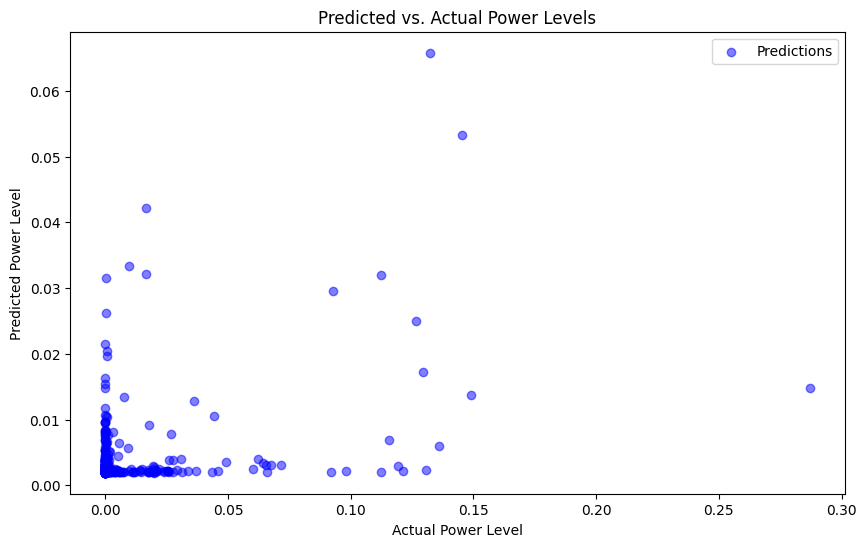

<ipython-input-5-7fa06a163cda>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df[usecols].apply(combine_features, axis=1)
<ipython-input-5-7fa06a163cda>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text'] = test_df[usecols].apply(combine_features, axis=1)


Map:   0%|          | 0/2313 [00:00<?, ? examples/s]

Map:   0%|          | 0/1454 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2313 [00:00<?, ? examples/s]

Map:   0%|          | 0/1454 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-5-7fa06a163cda>:98: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Epoch,Training Loss,Validation Loss,Mae
1,0.000600,0.000437,0.025740
2,0.000200,0.000244,0.012815
3,0.000100,0.000221,0.009107
4,0.000900,0.000216,0.007619
5,0.001000,0.000214,0.006765
6,0.000800,0.000214,0.007138
7,0.000100,0.000213,0.006291
8,0.000300,0.000212,0.006073
9,0.000100,0.000211,0.005916
10,0.000100,0.000209,0.005722


Evaluation results: {'eval_loss': 0.00020167964976280928, 'eval_mae': 0.0053164237178862095, 'eval_runtime': 37.9643, 'eval_samples_per_second': 38.299, 'eval_steps_per_second': 4.794, 'epoch': 17.0}
Top 10 Highest Predicted Values:
--------------------------------------------------
Name: Lumineon V, Predicted: 0.0198, Actual: 0.1267
Name: Lugia VSTAR, Predicted: 0.0198, Actual: 0.1125
Name: Arceus VSTAR, Predicted: 0.0186, Actual: 0.0928
Name: Pidgeot ex, Predicted: 0.0155, Actual: 0.0165
Name: Genesect V, Predicted: 0.0126, Actual: 0.1322
Name: Sylveon V, Predicted: 0.0118, Actual: 0.0000
Name: Mew ex, Predicted: 0.0113, Actual: 0.0095
Name: Galarian Articuno V, Predicted: 0.0113, Actual: 0.0003
Name: Regidrago VSTAR, Predicted: 0.0107, Actual: 0.0006
Name: Squawkabilly ex, Predicted: 0.0106, Actual: 0.0165

Top 10 Highest Actual Values:
--------------------------------------------------
Name: Comfey, Actual: 0.2870, Predicted: 0.0042
Name: Archeops, Actual: 0.1490, Predicted: 0.0042

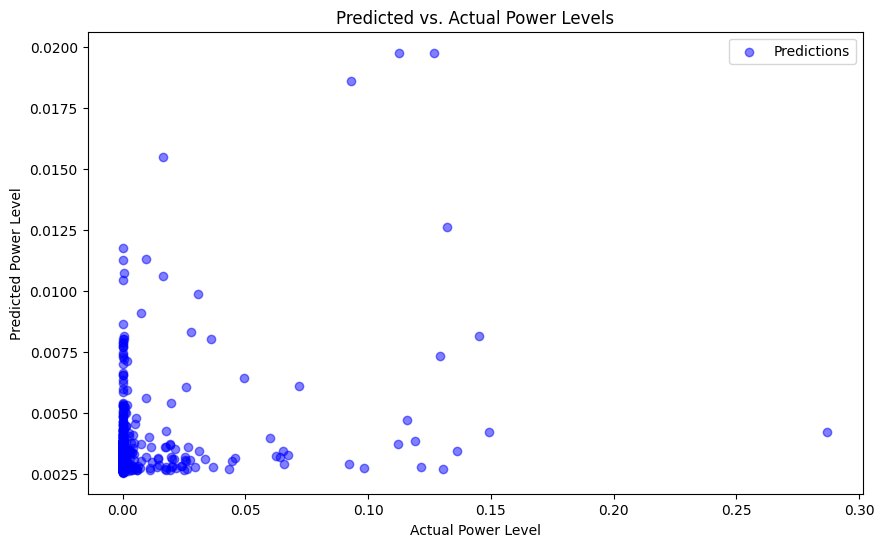

<ipython-input-5-7fa06a163cda>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df[usecols].apply(combine_features, axis=1)
<ipython-input-5-7fa06a163cda>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text'] = test_df[usecols].apply(combine_features, axis=1)


Map:   0%|          | 0/2313 [00:00<?, ? examples/s]

Map:   0%|          | 0/1454 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2313 [00:00<?, ? examples/s]

Map:   0%|          | 0/1454 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-5-7fa06a163cda>:98: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Epoch,Training Loss,Validation Loss,Mae
1,0.000300,0.000243,0.012675
2,0.000100,0.000216,0.007661
3,0.000100,0.000214,0.006348
4,0.000800,0.000213,0.008943
5,0.001000,0.000210,0.006694
6,0.000800,0.000215,0.011731


Evaluation results: {'eval_loss': 0.0002142245211871341, 'eval_mae': 0.006347761023789644, 'eval_runtime': 38.0479, 'eval_samples_per_second': 38.215, 'eval_steps_per_second': 4.783, 'epoch': 6.0}
Top 10 Highest Predicted Values:
--------------------------------------------------
Name: Spiral Energy, Predicted: 0.0060, Actual: 0.0000
Name: Regenerative Energy, Predicted: 0.0059, Actual: 0.0000
Name: Fusion Strike Energy, Predicted: 0.0059, Actual: 0.0000
Name: Treasure Energy, Predicted: 0.0058, Actual: 0.0000
Name: Impact Energy, Predicted: 0.0058, Actual: 0.0000
Name: Rapid Strike Energy, Predicted: 0.0057, Actual: 0.0000
Name: Lucky Energy, Predicted: 0.0056, Actual: 0.0000
Name: Single Strike Energy, Predicted: 0.0055, Actual: 0.0000
Name: Gift Energy, Predicted: 0.0054, Actual: 0.0000
Name: V Guard Energy, Predicted: 0.0053, Actual: 0.0000

Top 10 Highest Actual Values:
--------------------------------------------------
Name: Comfey, Actual: 0.2870, Predicted: 0.0043
Name: Archeop

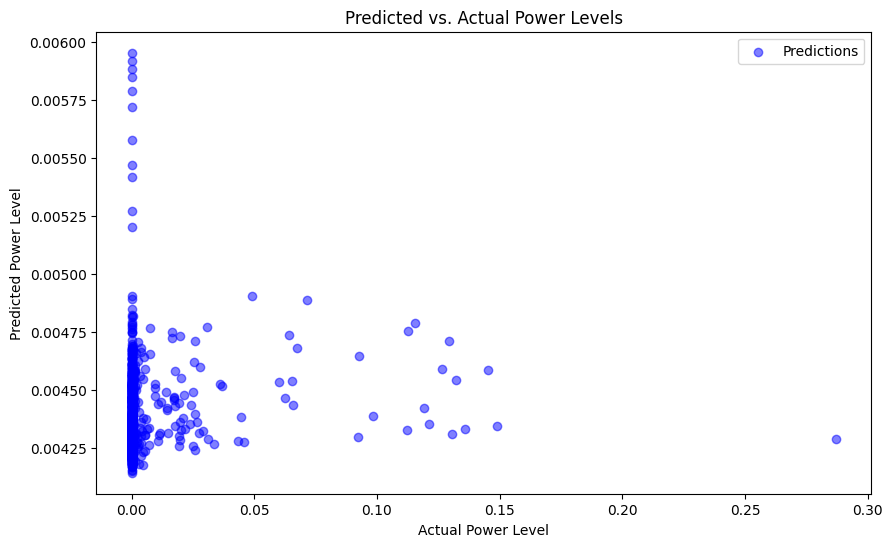

<ipython-input-5-7fa06a163cda>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df[usecols].apply(combine_features, axis=1)
<ipython-input-5-7fa06a163cda>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text'] = test_df[usecols].apply(combine_features, axis=1)


Map:   0%|          | 0/2313 [00:00<?, ? examples/s]

Map:   0%|          | 0/1454 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2313 [00:00<?, ? examples/s]

Map:   0%|          | 0/1454 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-5-7fa06a163cda>:98: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Epoch,Training Loss,Validation Loss,Mae
1,0.000300,0.000215,0.006984


In [ ]:
# Pokemon Roberta Fine Tuned Model
model_save_path = '/content/drive/MyDrive/266/project/pokemonRobertaTuned'

pokemon_concat = pd.concat([pokemon_2021, pokemon_2022], ignore_index=True)

train_and_evaluate_roberta_tuned_model(pokemon_concat, pokemon_2023, usecols, model_save_path)

<ipython-input-9-7fa06a163cda>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df[usecols].apply(combine_features, axis=1)
<ipython-input-9-7fa06a163cda>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text'] = test_df[usecols].apply(combine_features, axis=1)


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-9-7fa06a163cda>:98: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Epoch,Training Loss,Validation Loss,Mae
1,0.184100,0.152677,0.384390
2,0.006500,0.009217,0.055518
3,0.011700,0.008917,0.061931
4,0.009800,0.008813,0.062664
5,0.013400,0.008986,0.058138


Evaluation results: {'eval_loss': 0.009216812439262867, 'eval_mae': 0.055518005043268204, 'eval_runtime': 5.7686, 'eval_samples_per_second': 38.484, 'eval_steps_per_second': 4.854, 'epoch': 5.0}
Top 10 Highest Predicted Values:
--------------------------------------------------
Name: Switch, Predicted: 0.0498, Actual: 0.0936
Name: Great Ball, Predicted: 0.0468, Actual: 0.0096
Name: Gapejaw Bog, Predicted: 0.0454, Actual: 0.0006
Name: Energy Retrieval, Predicted: 0.0443, Actual: 0.0177
Name: Picnic Basket, Predicted: 0.0437, Actual: 0.0001
Name: Toy Catcher, Predicted: 0.0435, Actual: 0.0000
Name: Boss's Orders, Predicted: 0.0434, Actual: 0.4798
Name: Lake Acuity, Predicted: 0.0433, Actual: 0.0000
Name: Crystal Cave, Predicted: 0.0431, Actual: 0.0053
Name: Agatha, Predicted: 0.0429, Actual: 0.0001

Top 10 Highest Actual Values:
--------------------------------------------------
Name: Ultra Ball, Actual: 0.6744, Predicted: 0.0379
Name: Battle VIP Pass, Actual: 0.6656, Predicted: 0.0390
N

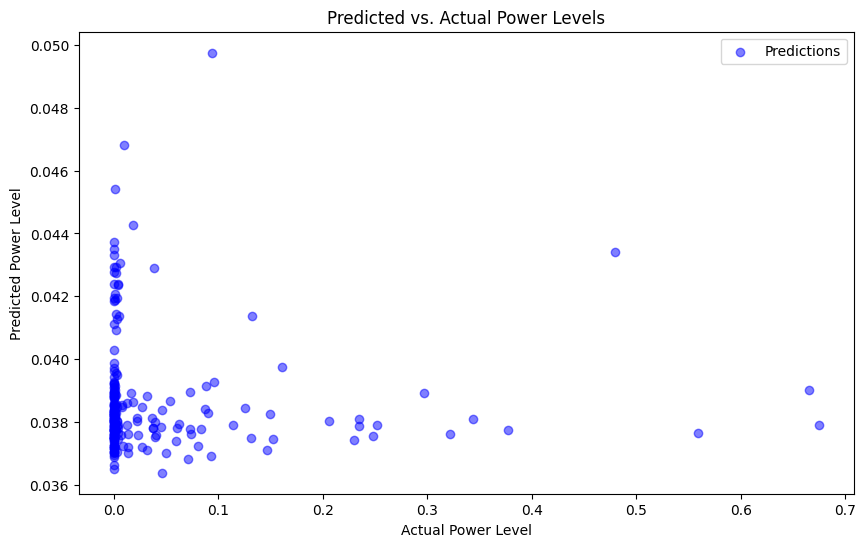

<ipython-input-9-7fa06a163cda>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df[usecols].apply(combine_features, axis=1)
<ipython-input-9-7fa06a163cda>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text'] = test_df[usecols].apply(combine_features, axis=1)


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-9-7fa06a163cda>:98: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Epoch,Training Loss,Validation Loss,Mae
1,0.251000,0.256582,0.499375
2,0.195500,0.187132,0.426085
3,0.014900,0.008913,0.066956
4,0.009000,0.009068,0.058671
5,0.013800,0.008846,0.065839
6,0.009800,0.009026,0.056815
7,0.022200,0.008647,0.069237
8,0.006800,0.008741,0.062907
9,0.019300,0.008722,0.057926


Evaluation results: {'eval_loss': 0.009025830775499344, 'eval_mae': 0.05681488290429115, 'eval_runtime': 5.7657, 'eval_samples_per_second': 38.504, 'eval_steps_per_second': 4.856, 'epoch': 9.0}
Top 10 Highest Predicted Values:
--------------------------------------------------
Name: Energy Search, Predicted: 0.0490, Actual: 0.0072
Name: Professor Burnet, Predicted: 0.0483, Actual: 0.0396
Name: Super Rod, Predicted: 0.0481, Actual: 0.1611
Name: Professor's Research, Predicted: 0.0478, Actual: 0.3436
Name: Pokégear 3.0, Predicted: 0.0477, Actual: 0.0604
Name: Switch, Predicted: 0.0477, Actual: 0.0936
Name: Great Ball, Predicted: 0.0475, Actual: 0.0096
Name: Town Store, Predicted: 0.0467, Actual: 0.0035
Name: Caitlin, Predicted: 0.0464, Actual: 0.0001
Name: Collapsed Stadium, Predicted: 0.0462, Actual: 0.0957

Top 10 Highest Actual Values:
--------------------------------------------------
Name: Ultra Ball, Actual: 0.6744, Predicted: 0.0457
Name: Battle VIP Pass, Actual: 0.6656, Predicted

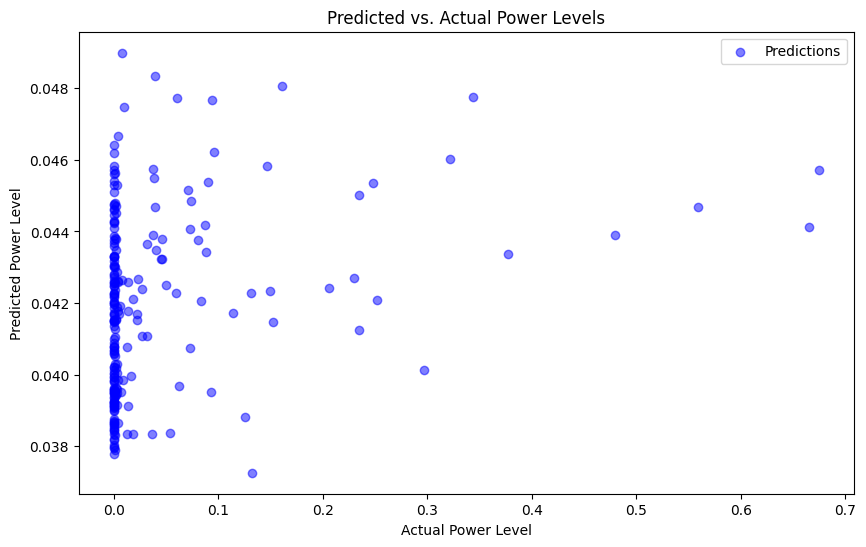

<ipython-input-9-7fa06a163cda>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df[usecols].apply(combine_features, axis=1)
<ipython-input-9-7fa06a163cda>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text'] = test_df[usecols].apply(combine_features, axis=1)


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-9-7fa06a163cda>:98: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Epoch,Training Loss,Validation Loss,Mae
1,0.252700,0.252774,0.495667
2,0.223400,0.219823,0.462005
3,0.088600,0.035879,0.180745
4,0.009700,0.008957,0.064176
5,0.013400,0.008839,0.069783
6,0.010300,0.009084,0.056741
7,0.022300,0.008888,0.061102
8,0.007600,0.008827,0.061669
9,0.019500,0.008618,0.071567


Evaluation results: {'eval_loss': 0.009084093384444714, 'eval_mae': 0.05674102529883385, 'eval_runtime': 5.7383, 'eval_samples_per_second': 38.687, 'eval_steps_per_second': 4.879, 'epoch': 9.0}
Top 10 Highest Predicted Values:
--------------------------------------------------
Name: Switch, Predicted: 0.0537, Actual: 0.0936
Name: Crushing Hammer, Predicted: 0.0489, Actual: 0.0022
Name: Spark, Predicted: 0.0483, Actual: 0.0000
Name: Antique Helix Fossil, Predicted: 0.0481, Actual: 0.0001
Name: Super Rod, Predicted: 0.0473, Actual: 0.1611
Name: Professor's Research, Predicted: 0.0465, Actual: 0.3436
Name: Exp. Share, Predicted: 0.0459, Actual: 0.0019
Name: Blanche, Predicted: 0.0458, Actual: 0.0000
Name: Defiance Band, Predicted: 0.0457, Actual: 0.0028
Name: Skaters' Park, Predicted: 0.0455, Actual: 0.0018

Top 10 Highest Actual Values:
--------------------------------------------------
Name: Ultra Ball, Actual: 0.6744, Predicted: 0.0450
Name: Battle VIP Pass, Actual: 0.6656, Predicted: 

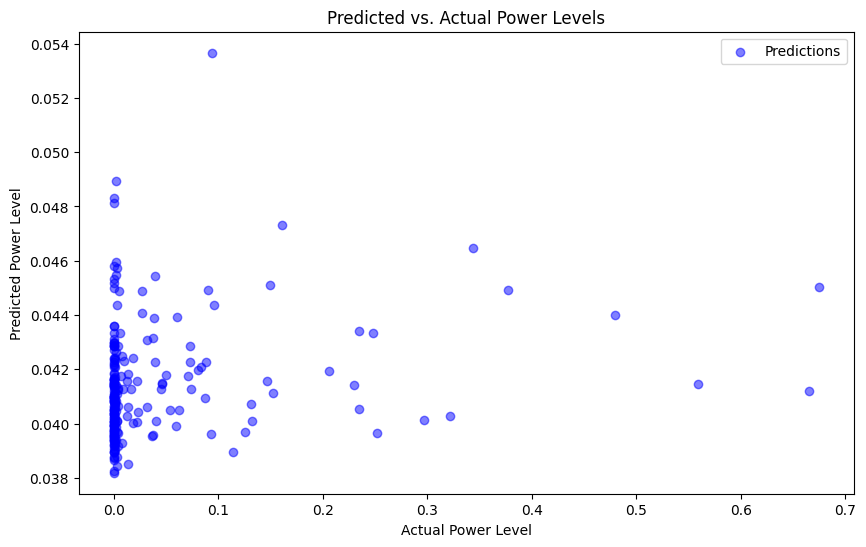

<ipython-input-9-7fa06a163cda>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df[usecols].apply(combine_features, axis=1)
<ipython-input-9-7fa06a163cda>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text'] = test_df[usecols].apply(combine_features, axis=1)


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-9-7fa06a163cda>:98: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Epoch,Training Loss,Validation Loss,Mae
1,0.235200,0.221349,0.463608
2,0.018000,0.009055,0.063420
3,0.011500,0.009064,0.057799
4,0.009600,0.009167,0.057462
5,0.013000,0.008771,0.077434
6,0.010700,0.009454,0.049669
7,0.021500,0.008580,0.066086
8,0.007700,0.008751,0.054969
9,0.020800,0.009054,0.051257


Evaluation results: {'eval_loss': 0.00945444218814373, 'eval_mae': 0.049668535590171814, 'eval_runtime': 5.6848, 'eval_samples_per_second': 39.052, 'eval_steps_per_second': 4.925, 'epoch': 9.0}
Top 10 Highest Predicted Values:
--------------------------------------------------
Name: Switch, Predicted: 0.0389, Actual: 0.0936
Name: Great Ball, Predicted: 0.0350, Actual: 0.0096
Name: Crushing Hammer, Predicted: 0.0339, Actual: 0.0022
Name: Skaters' Park, Predicted: 0.0331, Actual: 0.0018
Name: Super Rod, Predicted: 0.0326, Actual: 0.1611
Name: Exp. Share, Predicted: 0.0326, Actual: 0.0019
Name: Gapejaw Bog, Predicted: 0.0325, Actual: 0.0006
Name: Ultra Ball, Predicted: 0.0322, Actual: 0.6744
Name: Shopping Center, Predicted: 0.0320, Actual: 0.0000
Name: Temple of Sinnoh, Predicted: 0.0318, Actual: 0.0383

Top 10 Highest Actual Values:
--------------------------------------------------
Name: Ultra Ball, Actual: 0.6744, Predicted: 0.0322
Name: Battle VIP Pass, Actual: 0.6656, Predicted: 0.0

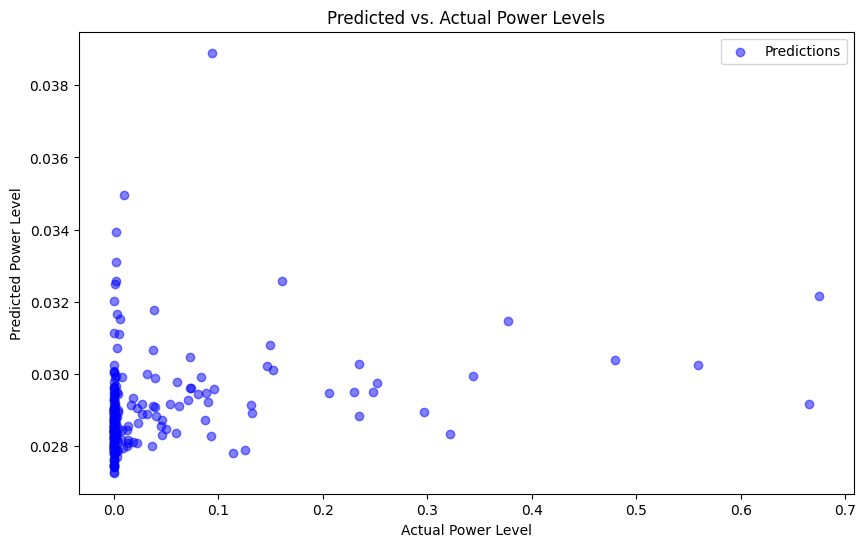

<ipython-input-9-7fa06a163cda>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df[usecols].apply(combine_features, axis=1)
<ipython-input-9-7fa06a163cda>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text'] = test_df[usecols].apply(combine_features, axis=1)


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-9-7fa06a163cda>:98: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Epoch,Training Loss,Validation Loss,Mae
1,0.118600,0.009004,0.069548
2,0.006900,0.009654,0.048087
3,0.011500,0.008790,0.065106
4,0.009500,0.008597,0.062127
5,0.011500,0.008587,0.056967


Evaluation results: {'eval_loss': 0.009654060937464237, 'eval_mae': 0.04808737710118294, 'eval_runtime': 5.7633, 'eval_samples_per_second': 38.519, 'eval_steps_per_second': 4.858, 'epoch': 5.0}
Top 10 Highest Predicted Values:
--------------------------------------------------
Name: Switch, Predicted: 0.0323, Actual: 0.0936
Name: Pokémon Catcher, Predicted: 0.0298, Actual: 0.0049
Name: Crushing Hammer, Predicted: 0.0297, Actual: 0.0022
Name: Skaters' Park, Predicted: 0.0294, Actual: 0.0018
Name: Shopping Center, Predicted: 0.0291, Actual: 0.0000
Name: Crystal Cave, Predicted: 0.0291, Actual: 0.0053
Name: Lake Acuity, Predicted: 0.0284, Actual: 0.0000
Name: Temple of Sinnoh, Predicted: 0.0276, Actual: 0.0383
Name: Exp. Share, Predicted: 0.0276, Actual: 0.0019
Name: Super Rod, Predicted: 0.0272, Actual: 0.1611

Top 10 Highest Actual Values:
--------------------------------------------------
Name: Ultra Ball, Actual: 0.6744, Predicted: 0.0254
Name: Battle VIP Pass, Actual: 0.6656, Predict

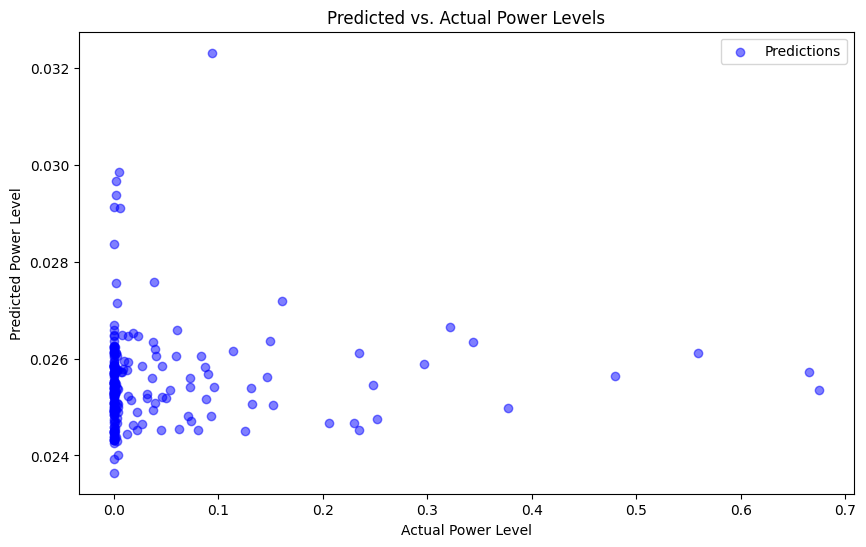

<ipython-input-9-7fa06a163cda>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df[usecols].apply(combine_features, axis=1)
<ipython-input-9-7fa06a163cda>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text'] = test_df[usecols].apply(combine_features, axis=1)


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-9-7fa06a163cda>:98: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Epoch,Training Loss,Validation Loss,Mae
1,0.251800,0.257850,0.500615
2,0.204200,0.200284,0.440777
3,0.019400,0.008922,0.073585
4,0.008900,0.008985,0.060703
5,0.013600,0.008881,0.065161
6,0.009800,0.008981,0.058004
7,0.022300,0.008713,0.064392
8,0.007000,0.008751,0.062722
9,0.019100,0.008619,0.058794


Evaluation results: {'eval_loss': 0.008980627171695232, 'eval_mae': 0.058003589510917664, 'eval_runtime': 5.7609, 'eval_samples_per_second': 38.536, 'eval_steps_per_second': 4.86, 'epoch': 9.0}
Top 10 Highest Predicted Values:
--------------------------------------------------
Name: Pokégear 3.0, Predicted: 0.0493, Actual: 0.0604
Name: Professor Burnet, Predicted: 0.0491, Actual: 0.0396
Name: Super Rod, Predicted: 0.0489, Actual: 0.1611
Name: Energy Search, Predicted: 0.0488, Actual: 0.0072
Name: Professor's Research, Predicted: 0.0487, Actual: 0.3436
Name: Town Store, Predicted: 0.0483, Actual: 0.0035
Name: Great Ball, Predicted: 0.0479, Actual: 0.0096
Name: Camping Gear, Predicted: 0.0478, Actual: 0.0000
Name: Caitlin, Predicted: 0.0476, Actual: 0.0001
Name: Level Ball, Predicted: 0.0475, Actual: 0.1461

Top 10 Highest Actual Values:
--------------------------------------------------
Name: Ultra Ball, Actual: 0.6744, Predicted: 0.0473
Name: Battle VIP Pass, Actual: 0.6656, Predicted:

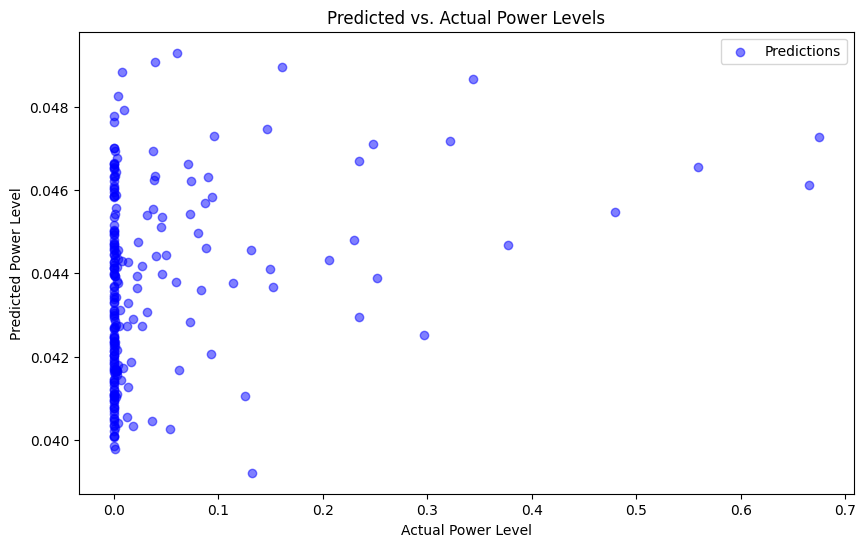

<ipython-input-9-7fa06a163cda>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df[usecols].apply(combine_features, axis=1)
<ipython-input-9-7fa06a163cda>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text'] = test_df[usecols].apply(combine_features, axis=1)


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-9-7fa06a163cda>:98: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Epoch,Training Loss,Validation Loss,Mae
1,0.257500,0.260253,0.502986
2,0.254300,0.257722,0.500522
3,0.257200,0.253359,0.496243
4,0.245000,0.246957,0.489897
5,0.234200,0.237055,0.479905
6,0.219900,0.219888,0.462063
7,0.202800,0.180225,0.417901
8,0.117800,0.086346,0.286673
9,0.044900,0.021551,0.135812
10,0.018600,0.009667,0.087600


Evaluation results: {'eval_loss': 0.009094233624637127, 'eval_mae': 0.057466086000204086, 'eval_runtime': 5.7453, 'eval_samples_per_second': 38.641, 'eval_steps_per_second': 4.874, 'epoch': 20.0}
Top 10 Highest Predicted Values:
--------------------------------------------------
Name: Switch, Predicted: 0.0583, Actual: 0.0936
Name: Crushing Hammer, Predicted: 0.0487, Actual: 0.0022
Name: Shopping Center, Predicted: 0.0481, Actual: 0.0000
Name: Super Rod, Predicted: 0.0478, Actual: 0.1611
Name: Roseanne's Backup, Predicted: 0.0477, Actual: 0.0001
Name: Antique Helix Fossil, Predicted: 0.0475, Actual: 0.0001
Name: Skaters' Park, Predicted: 0.0470, Actual: 0.0018
Name: Defiance Band, Predicted: 0.0469, Actual: 0.0028
Name: Exp. Share, Predicted: 0.0466, Actual: 0.0019
Name: Digging Duo, Predicted: 0.0463, Actual: 0.0000

Top 10 Highest Actual Values:
--------------------------------------------------
Name: Ultra Ball, Actual: 0.6744, Predicted: 0.0437
Name: Battle VIP Pass, Actual: 0.6656

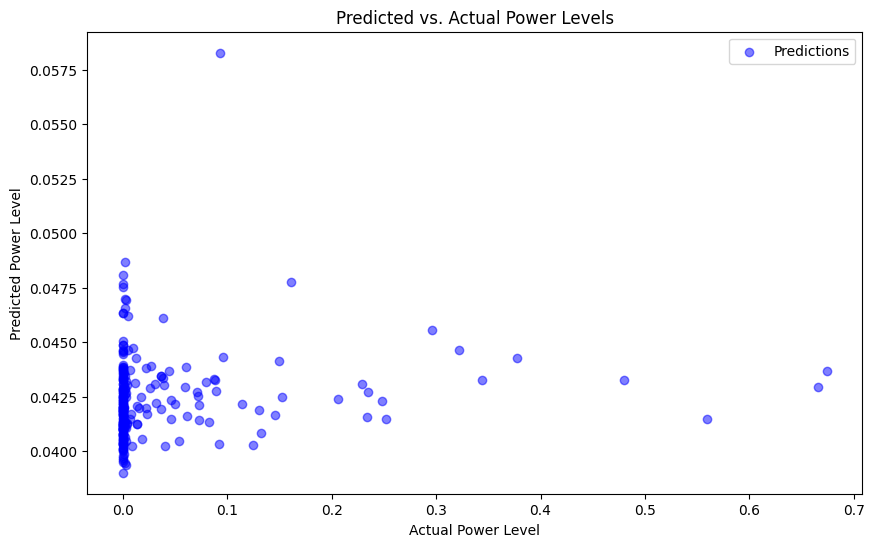

<ipython-input-9-7fa06a163cda>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df[usecols].apply(combine_features, axis=1)
<ipython-input-9-7fa06a163cda>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text'] = test_df[usecols].apply(combine_features, axis=1)


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-9-7fa06a163cda>:98: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Epoch,Training Loss,Validation Loss,Mae
1,0.197400,0.197054,0.437196
2,0.187000,0.195425,0.435379
3,0.183000,0.192673,0.432291
4,0.183800,0.188815,0.427922
5,0.174400,0.183444,0.421732
6,0.174000,0.176136,0.413184
7,0.171300,0.165034,0.399852
8,0.151900,0.145209,0.374738
9,0.107200,0.101038,0.311430
10,0.045500,0.032740,0.171644


Evaluation results: {'eval_loss': 0.00891249068081379, 'eval_mae': 0.06340585649013519, 'eval_runtime': 5.7106, 'eval_samples_per_second': 38.875, 'eval_steps_per_second': 4.903, 'epoch': 20.0}
Top 10 Highest Predicted Values:
--------------------------------------------------
Name: Switch, Predicted: 0.0669, Actual: 0.0936
Name: Shopping Center, Predicted: 0.0611, Actual: 0.0000
Name: Temple of Sinnoh, Predicted: 0.0610, Actual: 0.0383
Name: Super Rod, Predicted: 0.0586, Actual: 0.1611
Name: Great Ball, Predicted: 0.0585, Actual: 0.0096
Name: Dyna Tree Hill, Predicted: 0.0579, Actual: 0.0001
Name: Crystal Cave, Predicted: 0.0572, Actual: 0.0053
Name: Skaters' Park, Predicted: 0.0571, Actual: 0.0018
Name: Crushing Hammer, Predicted: 0.0567, Actual: 0.0022
Name: Collapsed Stadium, Predicted: 0.0567, Actual: 0.0957

Top 10 Highest Actual Values:
--------------------------------------------------
Name: Ultra Ball, Actual: 0.6744, Predicted: 0.0530
Name: Battle VIP Pass, Actual: 0.6656, Pr

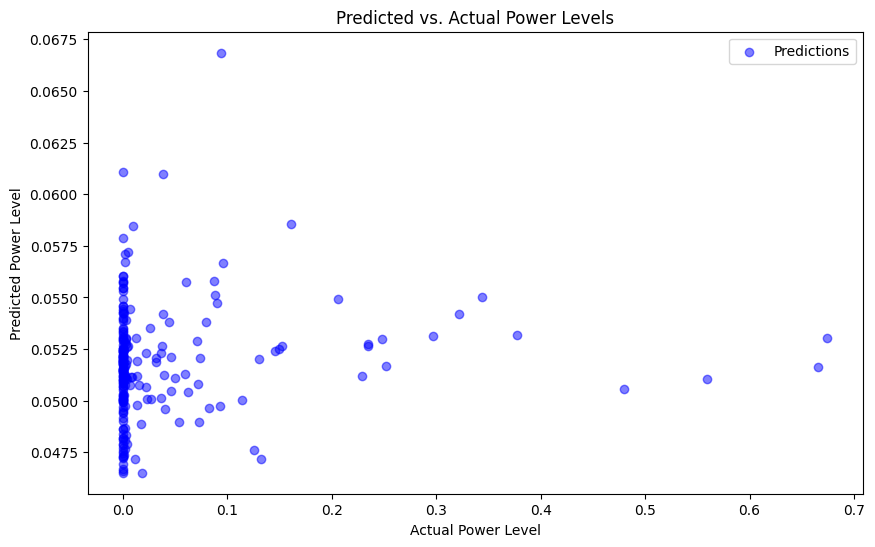

<ipython-input-9-7fa06a163cda>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df[usecols].apply(combine_features, axis=1)
<ipython-input-9-7fa06a163cda>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text'] = test_df[usecols].apply(combine_features, axis=1)


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-9-7fa06a163cda>:98: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Epoch,Training Loss,Validation Loss,Mae
1,0.197100,0.196680,0.436779
2,0.185700,0.193947,0.433723
3,0.179600,0.189270,0.428440
4,0.177000,0.182353,0.420468
5,0.162500,0.171435,0.407608
6,0.153500,0.152052,0.383584
7,0.122000,0.100610,0.310755
8,0.040500,0.022733,0.139773
9,0.023900,0.009405,0.083777
10,0.012700,0.008981,0.072750


Evaluation results: {'eval_loss': 0.008923530578613281, 'eval_mae': 0.061591170728206635, 'eval_runtime': 5.79, 'eval_samples_per_second': 38.342, 'eval_steps_per_second': 4.836, 'epoch': 20.0}
Top 10 Highest Predicted Values:
--------------------------------------------------
Name: Switch, Predicted: 0.0858, Actual: 0.0936
Name: Great Ball, Predicted: 0.0624, Actual: 0.0096
Name: Shopping Center, Predicted: 0.0601, Actual: 0.0000
Name: Temple of Sinnoh, Predicted: 0.0592, Actual: 0.0383
Name: Gapejaw Bog, Predicted: 0.0590, Actual: 0.0006
Name: Dyna Tree Hill, Predicted: 0.0565, Actual: 0.0001
Name: Skaters' Park, Predicted: 0.0559, Actual: 0.0018
Name: Crystal Cave, Predicted: 0.0558, Actual: 0.0053
Name: Crushing Hammer, Predicted: 0.0550, Actual: 0.0022
Name: Friends in Sinnoh, Predicted: 0.0547, Actual: 0.0000

Top 10 Highest Actual Values:
--------------------------------------------------
Name: Ultra Ball, Actual: 0.6744, Predicted: 0.0518
Name: Battle VIP Pass, Actual: 0.6656, 

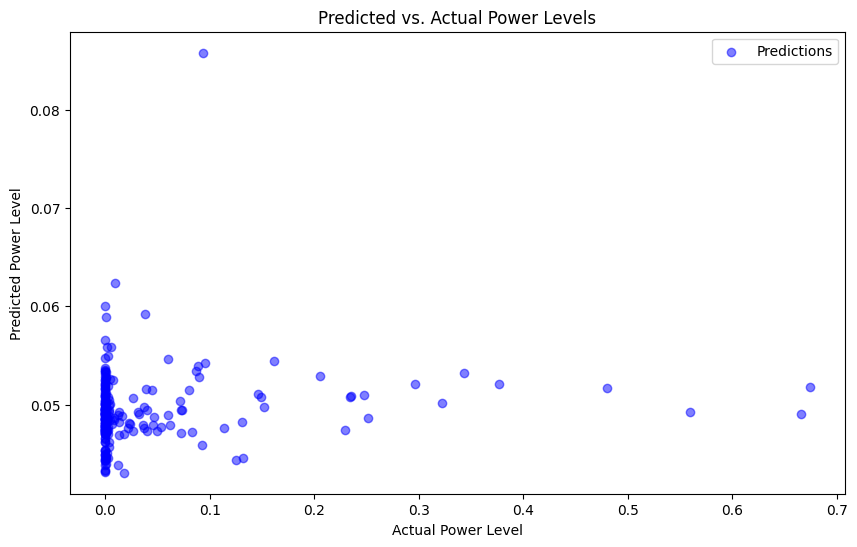

<ipython-input-9-7fa06a163cda>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df[usecols].apply(combine_features, axis=1)
<ipython-input-9-7fa06a163cda>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text'] = test_df[usecols].apply(combine_features, axis=1)


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-9-7fa06a163cda>:98: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Epoch,Training Loss,Validation Loss,Mae
1,0.153900,0.083559,0.282687
2,0.006700,0.009116,0.058012
3,0.011600,0.008981,0.057903
4,0.010100,0.008727,0.063828
5,0.013300,0.008353,0.062469
6,0.010200,0.009089,0.053697
7,0.022700,0.008476,0.065743
8,0.007400,0.009020,0.059423
9,0.019000,0.009101,0.044007
10,0.011500,0.008938,0.061913


Evaluation results: {'eval_loss': 0.009101364761590958, 'eval_mae': 0.04400685429573059, 'eval_runtime': 5.7711, 'eval_samples_per_second': 38.468, 'eval_steps_per_second': 4.852, 'epoch': 12.0}
Top 10 Highest Predicted Values:
--------------------------------------------------
Name: Boss's Orders, Predicted: 0.1900, Actual: 0.4798
Name: Professor's Research, Predicted: 0.1298, Actual: 0.3436
Name: Blanche, Predicted: 0.1070, Actual: 0.0000
Name: Candela, Predicted: 0.1060, Actual: 0.0000
Name: Spark, Predicted: 0.1046, Actual: 0.0000
Name: Professor Burnet, Predicted: 0.1043, Actual: 0.0396
Name: Klara, Predicted: 0.0994, Actual: 0.0898
Name: Switch, Predicted: 0.0776, Actual: 0.0936
Name: Pokégear 3.0, Predicted: 0.0391, Actual: 0.0604
Name: Toy Catcher, Predicted: 0.0358, Actual: 0.0000

Top 10 Highest Actual Values:
--------------------------------------------------
Name: Ultra Ball, Actual: 0.6744, Predicted: 0.0276
Name: Battle VIP Pass, Actual: 0.6656, Predicted: 0.0194
Name: Ne

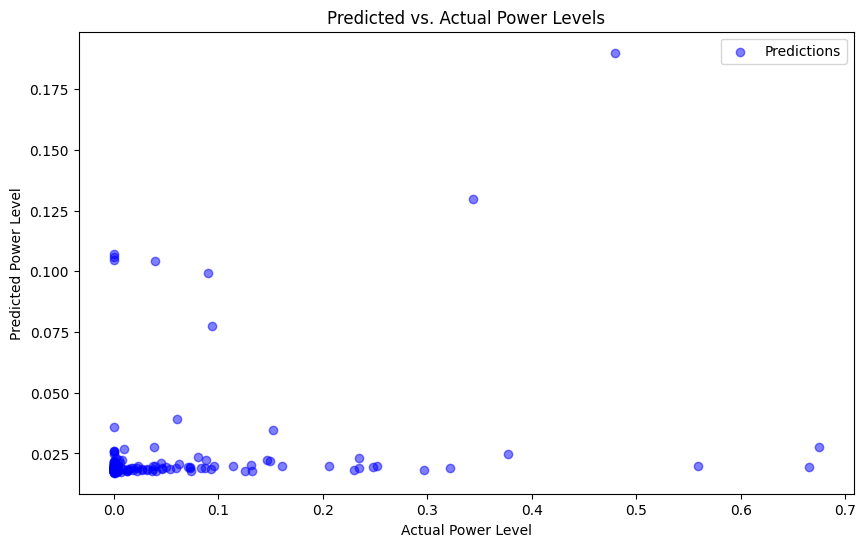

Best hyperparameters: [9.256818992066895e-05, np.int64(1200), 0.08599404067363209]
Best validation MAE: 0.04400685429573059
Training final model with the best hyperparameters...


<ipython-input-9-7fa06a163cda>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df[usecols].apply(combine_features, axis=1)
<ipython-input-9-7fa06a163cda>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text'] = test_df[usecols].apply(combine_features, axis=1)


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-9-7fa06a163cda>:98: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Epoch,Training Loss,Validation Loss,Mae
1,0.172500,0.054917,0.226762
2,0.006400,0.009313,0.052636
3,0.011600,0.008937,0.062708
4,0.009800,0.008668,0.068335
5,0.012200,0.008922,0.063731


Evaluation results: {'eval_loss': 0.009312557056546211, 'eval_mae': 0.05263550579547882, 'eval_runtime': 5.7422, 'eval_samples_per_second': 38.661, 'eval_steps_per_second': 4.876, 'epoch': 5.0}
Top 10 Highest Predicted Values:
--------------------------------------------------
Name: Switch, Predicted: 0.0426, Actual: 0.0936
Name: Great Ball, Predicted: 0.0412, Actual: 0.0096
Name: Shopping Center, Predicted: 0.0407, Actual: 0.0000
Name: Skaters' Park, Predicted: 0.0395, Actual: 0.0018
Name: Gapejaw Bog, Predicted: 0.0391, Actual: 0.0006
Name: Temple of Sinnoh, Predicted: 0.0388, Actual: 0.0383
Name: Lake Acuity, Predicted: 0.0382, Actual: 0.0000
Name: Crystal Cave, Predicted: 0.0380, Actual: 0.0053
Name: Crushing Hammer, Predicted: 0.0366, Actual: 0.0022
Name: Defiance Band, Predicted: 0.0364, Actual: 0.0028

Top 10 Highest Actual Values:
--------------------------------------------------
Name: Ultra Ball, Actual: 0.6744, Predicted: 0.0340
Name: Battle VIP Pass, Actual: 0.6656, Predict

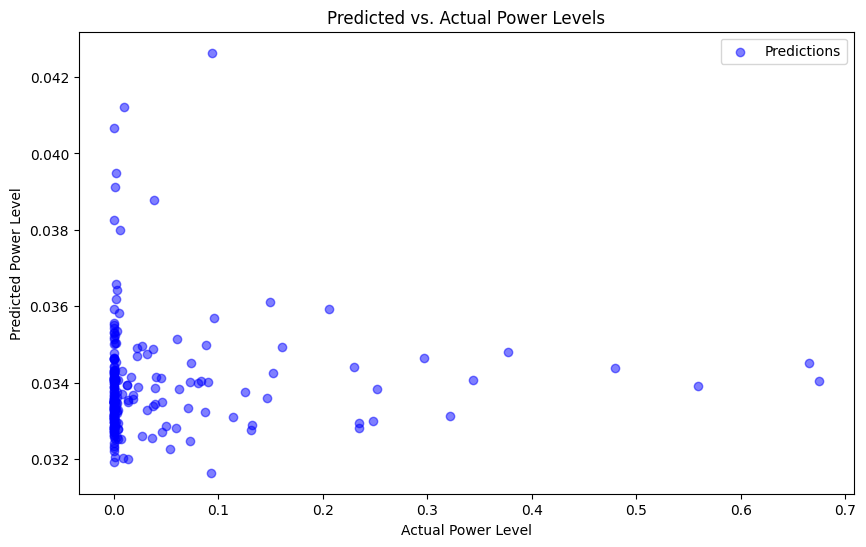

Saving the best model to /content/drive/MyDrive/266/project/trainerRobertaTuned


AttributeError: 'float' object has no attribute 'save_model'

In [ ]:
# Trainer Roberta Fine Tuned Model
model_save_path = '/content/drive/MyDrive/266/project/trainerRobertaTuned'

trainer_concat = pd.concat([trainer_2021, trainer_2022], ignore_index=True)

train_and_evaluate_roberta_tuned_model(trainer_concat, trainer_2023, usecols, model_save_path)

<ipython-input-21-2a7ed30193fa>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df[usecols].apply(combine_features, axis=1)
<ipython-input-21-2a7ed30193fa>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text'] = test_df[usecols].apply(combine_features, axis=1)


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-21-2a7ed30193fa>:98: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Epoch,Training Loss,Validation Loss,Mae
1,0.193500,0.172388,0.408840
2,0.006300,0.009250,0.053997
3,0.011200,0.008728,0.068288
4,0.009600,0.008613,0.064367
5,0.012500,0.008294,0.068910


{'eval_loss': 0.009250286035239697, 'eval_mae': 0.05399679020047188, 'eval_runtime': 5.886, 'eval_samples_per_second': 37.717, 'eval_steps_per_second': 4.757, 'epoch': 5.0}
Top 10 Highest Predicted Values:
--------------------------------------------------
Name: Switch, Predicted: 0.0421, Actual: 0.0936
Name: Great Ball, Predicted: 0.0406, Actual: 0.0096
Name: Shopping Center, Predicted: 0.0392, Actual: 0.0000
Name: Temple of Sinnoh, Predicted: 0.0391, Actual: 0.0383
Name: Crystal Cave, Predicted: 0.0388, Actual: 0.0053
Name: Gapejaw Bog, Predicted: 0.0386, Actual: 0.0006
Name: Town Store, Predicted: 0.0381, Actual: 0.0035
Name: Pokégear 3.0, Predicted: 0.0380, Actual: 0.0604
Name: Artazon, Predicted: 0.0380, Actual: 0.0372
Name: Electric Generator, Predicted: 0.0380, Actual: 0.0499

Top 10 Highest Actual Values:
--------------------------------------------------
Name: Ultra Ball, Actual: 0.6744, Predicted: 0.0366
Name: Battle VIP Pass, Actual: 0.6656, Predicted: 0.0361
Name: Nest Ball

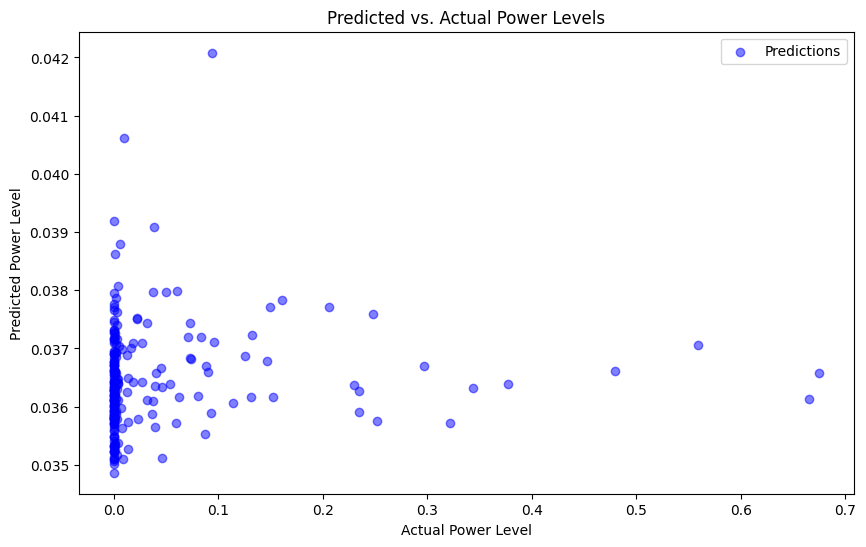

<ipython-input-21-2a7ed30193fa>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df[usecols].apply(combine_features, axis=1)
<ipython-input-21-2a7ed30193fa>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text'] = test_df[usecols].apply(combine_features, axis=1)


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-21-2a7ed30193fa>:98: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Epoch,Training Loss,Validation Loss,Mae
1,0.251000,0.256582,0.499375
2,0.195500,0.187132,0.426085
3,0.014900,0.008913,0.066956
4,0.009000,0.009068,0.058671
5,0.013800,0.008846,0.065839
6,0.009800,0.009026,0.056815
7,0.022200,0.008647,0.069237
8,0.006800,0.008741,0.062907
9,0.019300,0.008722,0.057926


{'eval_loss': 0.009025830775499344, 'eval_mae': 0.05681488290429115, 'eval_runtime': 5.8943, 'eval_samples_per_second': 37.663, 'eval_steps_per_second': 4.75, 'epoch': 9.0}
Top 10 Highest Predicted Values:
--------------------------------------------------
Name: Energy Search, Predicted: 0.0490, Actual: 0.0072
Name: Professor Burnet, Predicted: 0.0483, Actual: 0.0396
Name: Super Rod, Predicted: 0.0481, Actual: 0.1611
Name: Professor's Research, Predicted: 0.0478, Actual: 0.3436
Name: Pokégear 3.0, Predicted: 0.0477, Actual: 0.0604
Name: Switch, Predicted: 0.0477, Actual: 0.0936
Name: Great Ball, Predicted: 0.0475, Actual: 0.0096
Name: Town Store, Predicted: 0.0467, Actual: 0.0035
Name: Caitlin, Predicted: 0.0464, Actual: 0.0001
Name: Collapsed Stadium, Predicted: 0.0462, Actual: 0.0957

Top 10 Highest Actual Values:
--------------------------------------------------
Name: Ultra Ball, Actual: 0.6744, Predicted: 0.0457
Name: Battle VIP Pass, Actual: 0.6656, Predicted: 0.0441
Name: Nest B

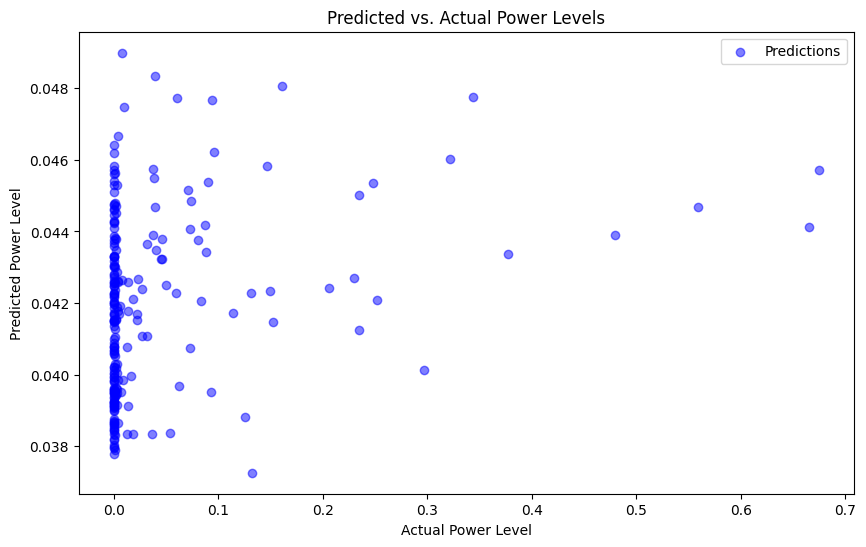

<ipython-input-21-2a7ed30193fa>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df[usecols].apply(combine_features, axis=1)
<ipython-input-21-2a7ed30193fa>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text'] = test_df[usecols].apply(combine_features, axis=1)


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-21-2a7ed30193fa>:98: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Epoch,Training Loss,Validation Loss,Mae
1,0.252700,0.252774,0.495667
2,0.223400,0.219823,0.462005
3,0.088600,0.035879,0.180745
4,0.009700,0.008957,0.064176
5,0.013400,0.008839,0.069783
6,0.010300,0.009084,0.056741
7,0.022300,0.008888,0.061102
8,0.007600,0.008827,0.061669
9,0.019500,0.008618,0.071567


{'eval_loss': 0.009084093384444714, 'eval_mae': 0.05674102529883385, 'eval_runtime': 5.7912, 'eval_samples_per_second': 38.334, 'eval_steps_per_second': 4.835, 'epoch': 9.0}
Top 10 Highest Predicted Values:
--------------------------------------------------
Name: Switch, Predicted: 0.0537, Actual: 0.0936
Name: Crushing Hammer, Predicted: 0.0489, Actual: 0.0022
Name: Spark, Predicted: 0.0483, Actual: 0.0000
Name: Antique Helix Fossil, Predicted: 0.0481, Actual: 0.0001
Name: Super Rod, Predicted: 0.0473, Actual: 0.1611
Name: Professor's Research, Predicted: 0.0465, Actual: 0.3436
Name: Exp. Share, Predicted: 0.0459, Actual: 0.0019
Name: Blanche, Predicted: 0.0458, Actual: 0.0000
Name: Defiance Band, Predicted: 0.0457, Actual: 0.0028
Name: Skaters' Park, Predicted: 0.0455, Actual: 0.0018

Top 10 Highest Actual Values:
--------------------------------------------------
Name: Ultra Ball, Actual: 0.6744, Predicted: 0.0450
Name: Battle VIP Pass, Actual: 0.6656, Predicted: 0.0412
Name: Nest Ba

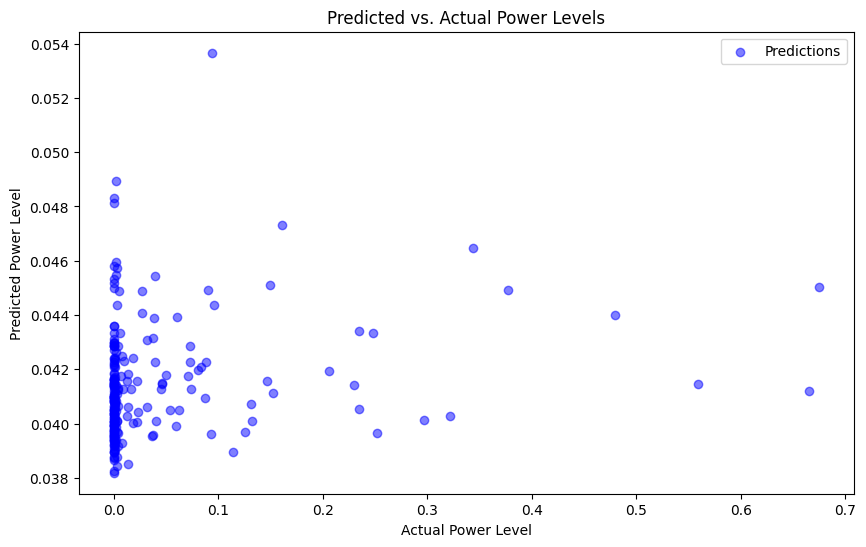

<ipython-input-21-2a7ed30193fa>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df[usecols].apply(combine_features, axis=1)
<ipython-input-21-2a7ed30193fa>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text'] = test_df[usecols].apply(combine_features, axis=1)


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-21-2a7ed30193fa>:98: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Epoch,Training Loss,Validation Loss,Mae
1,0.235200,0.221349,0.463608
2,0.018000,0.009055,0.063420
3,0.011500,0.009064,0.057799
4,0.009600,0.009167,0.057462
5,0.013000,0.008771,0.077434
6,0.010700,0.009454,0.049669
7,0.021500,0.008580,0.066086
8,0.007700,0.008751,0.054969
9,0.020800,0.009054,0.051257


{'eval_loss': 0.00945444218814373, 'eval_mae': 0.049668535590171814, 'eval_runtime': 5.909, 'eval_samples_per_second': 37.57, 'eval_steps_per_second': 4.739, 'epoch': 9.0}
Top 10 Highest Predicted Values:
--------------------------------------------------
Name: Switch, Predicted: 0.0389, Actual: 0.0936
Name: Great Ball, Predicted: 0.0350, Actual: 0.0096
Name: Crushing Hammer, Predicted: 0.0339, Actual: 0.0022
Name: Skaters' Park, Predicted: 0.0331, Actual: 0.0018
Name: Super Rod, Predicted: 0.0326, Actual: 0.1611
Name: Exp. Share, Predicted: 0.0326, Actual: 0.0019
Name: Gapejaw Bog, Predicted: 0.0325, Actual: 0.0006
Name: Ultra Ball, Predicted: 0.0322, Actual: 0.6744
Name: Shopping Center, Predicted: 0.0320, Actual: 0.0000
Name: Temple of Sinnoh, Predicted: 0.0318, Actual: 0.0383

Top 10 Highest Actual Values:
--------------------------------------------------
Name: Ultra Ball, Actual: 0.6744, Predicted: 0.0322
Name: Battle VIP Pass, Actual: 0.6656, Predicted: 0.0292
Name: Nest Ball, A

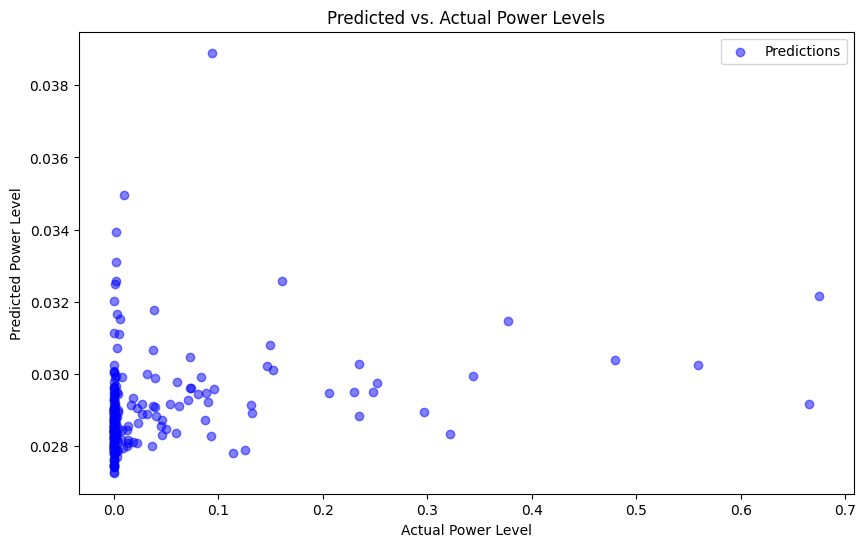

<ipython-input-21-2a7ed30193fa>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df[usecols].apply(combine_features, axis=1)
<ipython-input-21-2a7ed30193fa>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text'] = test_df[usecols].apply(combine_features, axis=1)


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-21-2a7ed30193fa>:98: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Epoch,Training Loss,Validation Loss,Mae
1,0.118600,0.009004,0.069548
2,0.006900,0.009654,0.048087
3,0.011500,0.008790,0.065106
4,0.009500,0.008597,0.062127
5,0.011500,0.008587,0.056967


{'eval_loss': 0.009654060937464237, 'eval_mae': 0.04808737710118294, 'eval_runtime': 5.9007, 'eval_samples_per_second': 37.623, 'eval_steps_per_second': 4.745, 'epoch': 5.0}
Top 10 Highest Predicted Values:
--------------------------------------------------
Name: Switch, Predicted: 0.0323, Actual: 0.0936
Name: Pokémon Catcher, Predicted: 0.0298, Actual: 0.0049
Name: Crushing Hammer, Predicted: 0.0297, Actual: 0.0022
Name: Skaters' Park, Predicted: 0.0294, Actual: 0.0018
Name: Shopping Center, Predicted: 0.0291, Actual: 0.0000
Name: Crystal Cave, Predicted: 0.0291, Actual: 0.0053
Name: Lake Acuity, Predicted: 0.0284, Actual: 0.0000
Name: Temple of Sinnoh, Predicted: 0.0276, Actual: 0.0383
Name: Exp. Share, Predicted: 0.0276, Actual: 0.0019
Name: Super Rod, Predicted: 0.0272, Actual: 0.1611

Top 10 Highest Actual Values:
--------------------------------------------------
Name: Ultra Ball, Actual: 0.6744, Predicted: 0.0254
Name: Battle VIP Pass, Actual: 0.6656, Predicted: 0.0257
Name: Nes

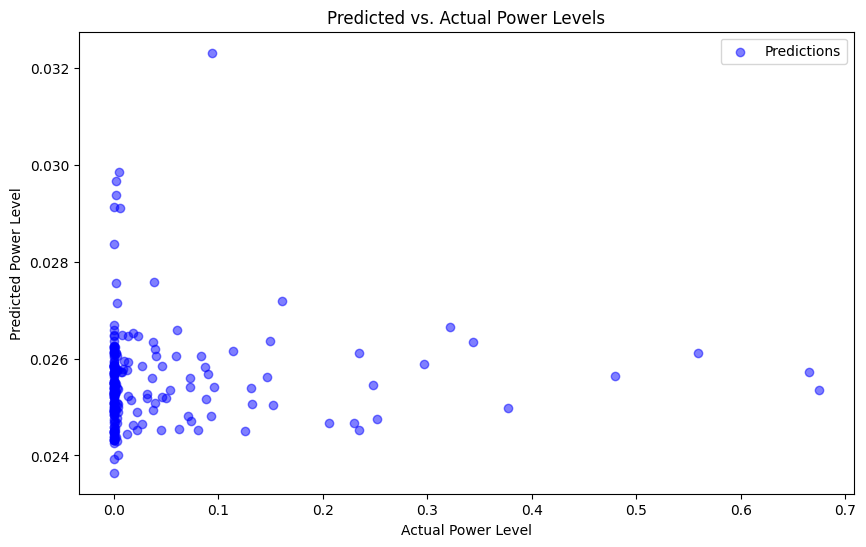

<ipython-input-21-2a7ed30193fa>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df[usecols].apply(combine_features, axis=1)
<ipython-input-21-2a7ed30193fa>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text'] = test_df[usecols].apply(combine_features, axis=1)


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-21-2a7ed30193fa>:98: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Epoch,Training Loss,Validation Loss,Mae
1,0.251800,0.257850,0.500615
2,0.204200,0.200284,0.440777
3,0.019400,0.008922,0.073585
4,0.008900,0.008985,0.060703
5,0.013600,0.008881,0.065161
6,0.009800,0.008981,0.058004
7,0.022300,0.008713,0.064392
8,0.007000,0.008751,0.062722
9,0.019100,0.008619,0.058794


{'eval_loss': 0.008980627171695232, 'eval_mae': 0.058003589510917664, 'eval_runtime': 5.9091, 'eval_samples_per_second': 37.569, 'eval_steps_per_second': 4.738, 'epoch': 9.0}
Top 10 Highest Predicted Values:
--------------------------------------------------
Name: Pokégear 3.0, Predicted: 0.0493, Actual: 0.0604
Name: Professor Burnet, Predicted: 0.0491, Actual: 0.0396
Name: Super Rod, Predicted: 0.0489, Actual: 0.1611
Name: Energy Search, Predicted: 0.0488, Actual: 0.0072
Name: Professor's Research, Predicted: 0.0487, Actual: 0.3436
Name: Town Store, Predicted: 0.0483, Actual: 0.0035
Name: Great Ball, Predicted: 0.0479, Actual: 0.0096
Name: Camping Gear, Predicted: 0.0478, Actual: 0.0000
Name: Caitlin, Predicted: 0.0476, Actual: 0.0001
Name: Level Ball, Predicted: 0.0475, Actual: 0.1461

Top 10 Highest Actual Values:
--------------------------------------------------
Name: Ultra Ball, Actual: 0.6744, Predicted: 0.0473
Name: Battle VIP Pass, Actual: 0.6656, Predicted: 0.0461
Name: Nest 

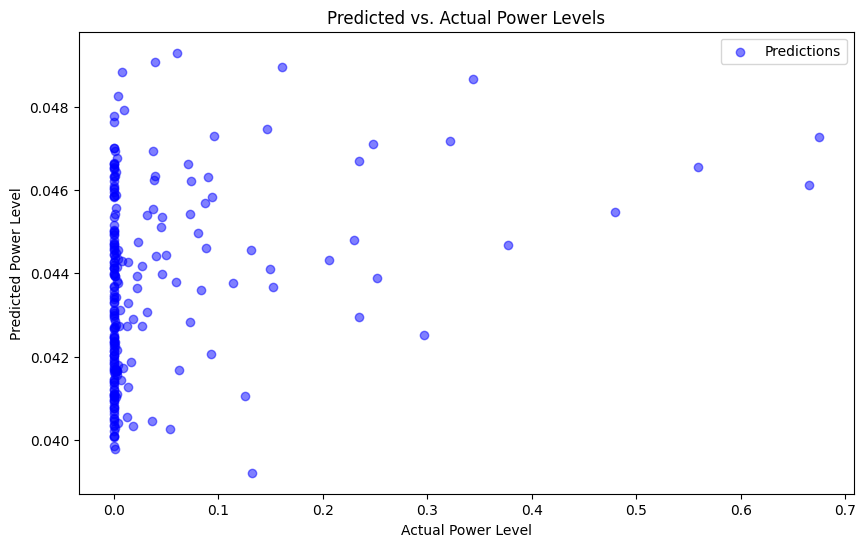

<ipython-input-21-2a7ed30193fa>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df[usecols].apply(combine_features, axis=1)
<ipython-input-21-2a7ed30193fa>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text'] = test_df[usecols].apply(combine_features, axis=1)


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-21-2a7ed30193fa>:98: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Epoch,Training Loss,Validation Loss,Mae
1,0.257500,0.260253,0.502986
2,0.254300,0.257722,0.500522
3,0.257200,0.253359,0.496243
4,0.245000,0.246957,0.489897
5,0.234200,0.237055,0.479905
6,0.219900,0.219888,0.462063
7,0.202800,0.180225,0.417901
8,0.117800,0.086346,0.286673
9,0.044900,0.021551,0.135812
10,0.018600,0.009667,0.087600


{'eval_loss': 0.009094233624637127, 'eval_mae': 0.057466086000204086, 'eval_runtime': 5.9435, 'eval_samples_per_second': 37.352, 'eval_steps_per_second': 4.711, 'epoch': 20.0}
Top 10 Highest Predicted Values:
--------------------------------------------------
Name: Switch, Predicted: 0.0583, Actual: 0.0936
Name: Crushing Hammer, Predicted: 0.0487, Actual: 0.0022
Name: Shopping Center, Predicted: 0.0481, Actual: 0.0000
Name: Super Rod, Predicted: 0.0478, Actual: 0.1611
Name: Roseanne's Backup, Predicted: 0.0477, Actual: 0.0001
Name: Antique Helix Fossil, Predicted: 0.0475, Actual: 0.0001
Name: Skaters' Park, Predicted: 0.0470, Actual: 0.0018
Name: Defiance Band, Predicted: 0.0469, Actual: 0.0028
Name: Exp. Share, Predicted: 0.0466, Actual: 0.0019
Name: Digging Duo, Predicted: 0.0463, Actual: 0.0000

Top 10 Highest Actual Values:
--------------------------------------------------
Name: Ultra Ball, Actual: 0.6744, Predicted: 0.0437
Name: Battle VIP Pass, Actual: 0.6656, Predicted: 0.0430


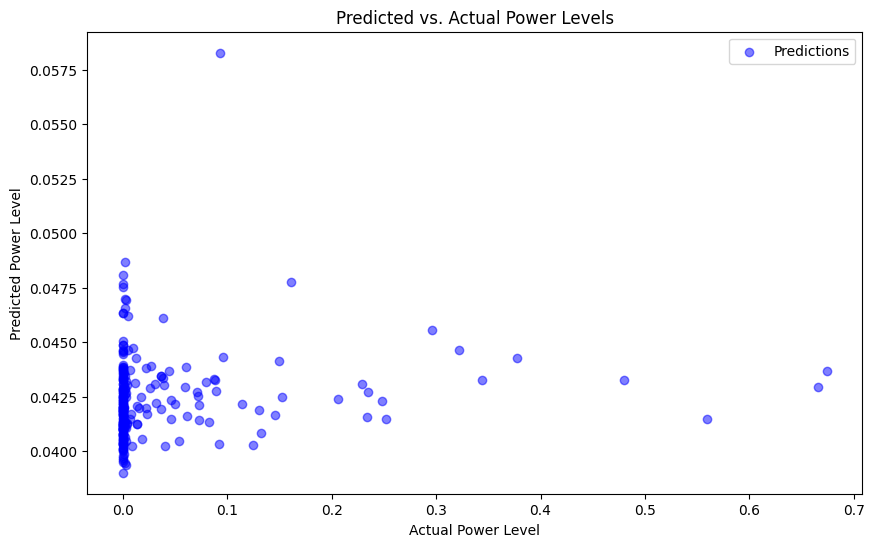

<ipython-input-21-2a7ed30193fa>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df[usecols].apply(combine_features, axis=1)
<ipython-input-21-2a7ed30193fa>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text'] = test_df[usecols].apply(combine_features, axis=1)


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-21-2a7ed30193fa>:98: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Epoch,Training Loss,Validation Loss,Mae
1,0.197400,0.197054,0.437196
2,0.187000,0.195425,0.435379
3,0.183000,0.192673,0.432291
4,0.183800,0.188815,0.427922
5,0.174400,0.183444,0.421732
6,0.174000,0.176136,0.413184
7,0.171300,0.165034,0.399852
8,0.151900,0.145209,0.374738
9,0.107200,0.101038,0.311430
10,0.045500,0.032740,0.171644


{'eval_loss': 0.00891249068081379, 'eval_mae': 0.06340585649013519, 'eval_runtime': 5.9613, 'eval_samples_per_second': 37.24, 'eval_steps_per_second': 4.697, 'epoch': 20.0}
Top 10 Highest Predicted Values:
--------------------------------------------------
Name: Switch, Predicted: 0.0669, Actual: 0.0936
Name: Shopping Center, Predicted: 0.0611, Actual: 0.0000
Name: Temple of Sinnoh, Predicted: 0.0610, Actual: 0.0383
Name: Super Rod, Predicted: 0.0586, Actual: 0.1611
Name: Great Ball, Predicted: 0.0585, Actual: 0.0096
Name: Dyna Tree Hill, Predicted: 0.0579, Actual: 0.0001
Name: Crystal Cave, Predicted: 0.0572, Actual: 0.0053
Name: Skaters' Park, Predicted: 0.0571, Actual: 0.0018
Name: Crushing Hammer, Predicted: 0.0567, Actual: 0.0022
Name: Collapsed Stadium, Predicted: 0.0567, Actual: 0.0957

Top 10 Highest Actual Values:
--------------------------------------------------
Name: Ultra Ball, Actual: 0.6744, Predicted: 0.0530
Name: Battle VIP Pass, Actual: 0.6656, Predicted: 0.0516
Name:

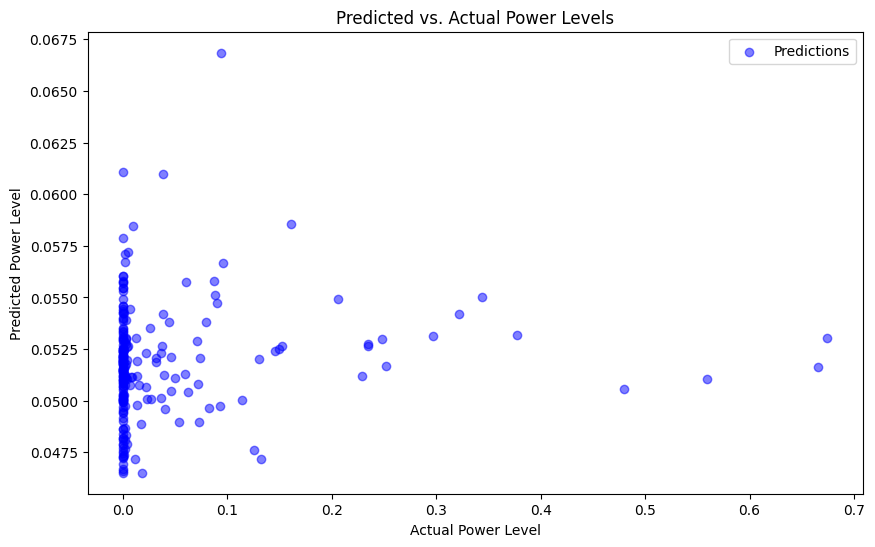

<ipython-input-21-2a7ed30193fa>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df[usecols].apply(combine_features, axis=1)
<ipython-input-21-2a7ed30193fa>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text'] = test_df[usecols].apply(combine_features, axis=1)


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-21-2a7ed30193fa>:98: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Epoch,Training Loss,Validation Loss,Mae
1,0.197100,0.196680,0.436779
2,0.185700,0.193947,0.433723
3,0.179600,0.189270,0.428440
4,0.177000,0.182353,0.420468
5,0.162500,0.171435,0.407608
6,0.153500,0.152052,0.383584
7,0.122000,0.100610,0.310755
8,0.040500,0.022733,0.139773
9,0.023900,0.009405,0.083777
10,0.012700,0.008981,0.072750


{'eval_loss': 0.008923530578613281, 'eval_mae': 0.061591170728206635, 'eval_runtime': 5.8789, 'eval_samples_per_second': 37.762, 'eval_steps_per_second': 4.763, 'epoch': 20.0}
Top 10 Highest Predicted Values:
--------------------------------------------------
Name: Switch, Predicted: 0.0858, Actual: 0.0936
Name: Great Ball, Predicted: 0.0624, Actual: 0.0096
Name: Shopping Center, Predicted: 0.0601, Actual: 0.0000
Name: Temple of Sinnoh, Predicted: 0.0592, Actual: 0.0383
Name: Gapejaw Bog, Predicted: 0.0590, Actual: 0.0006
Name: Dyna Tree Hill, Predicted: 0.0565, Actual: 0.0001
Name: Skaters' Park, Predicted: 0.0559, Actual: 0.0018
Name: Crystal Cave, Predicted: 0.0558, Actual: 0.0053
Name: Crushing Hammer, Predicted: 0.0550, Actual: 0.0022
Name: Friends in Sinnoh, Predicted: 0.0547, Actual: 0.0000

Top 10 Highest Actual Values:
--------------------------------------------------
Name: Ultra Ball, Actual: 0.6744, Predicted: 0.0518
Name: Battle VIP Pass, Actual: 0.6656, Predicted: 0.0491


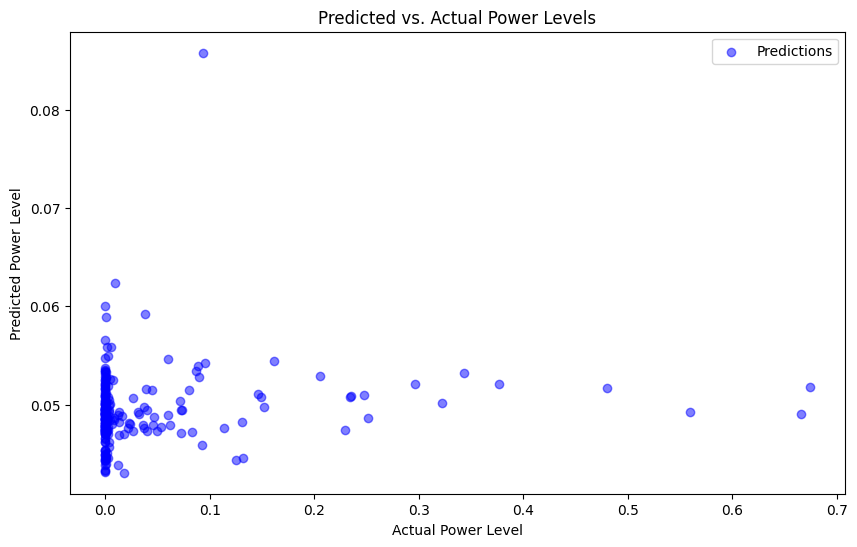

<ipython-input-21-2a7ed30193fa>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df[usecols].apply(combine_features, axis=1)
<ipython-input-21-2a7ed30193fa>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text'] = test_df[usecols].apply(combine_features, axis=1)


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-21-2a7ed30193fa>:98: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Epoch,Training Loss,Validation Loss,Mae
1,0.153900,0.083559,0.282687
2,0.006700,0.009116,0.058012
3,0.011600,0.008981,0.057903
4,0.010100,0.008727,0.063828
5,0.013300,0.008353,0.062469
6,0.010200,0.009089,0.053697
7,0.022700,0.008476,0.065743
8,0.007400,0.009020,0.059423
9,0.019000,0.009101,0.044007
10,0.011500,0.008938,0.061913


{'eval_loss': 0.009101364761590958, 'eval_mae': 0.04400685429573059, 'eval_runtime': 5.8755, 'eval_samples_per_second': 37.784, 'eval_steps_per_second': 4.766, 'epoch': 12.0}
Top 10 Highest Predicted Values:
--------------------------------------------------
Name: Boss's Orders, Predicted: 0.1900, Actual: 0.4798
Name: Professor's Research, Predicted: 0.1298, Actual: 0.3436
Name: Blanche, Predicted: 0.1070, Actual: 0.0000
Name: Candela, Predicted: 0.1060, Actual: 0.0000
Name: Spark, Predicted: 0.1046, Actual: 0.0000
Name: Professor Burnet, Predicted: 0.1043, Actual: 0.0396
Name: Klara, Predicted: 0.0994, Actual: 0.0898
Name: Switch, Predicted: 0.0776, Actual: 0.0936
Name: Pokégear 3.0, Predicted: 0.0391, Actual: 0.0604
Name: Toy Catcher, Predicted: 0.0358, Actual: 0.0000

Top 10 Highest Actual Values:
--------------------------------------------------
Name: Ultra Ball, Actual: 0.6744, Predicted: 0.0276
Name: Battle VIP Pass, Actual: 0.6656, Predicted: 0.0194
Name: Nest Ball, Actual: 0.5

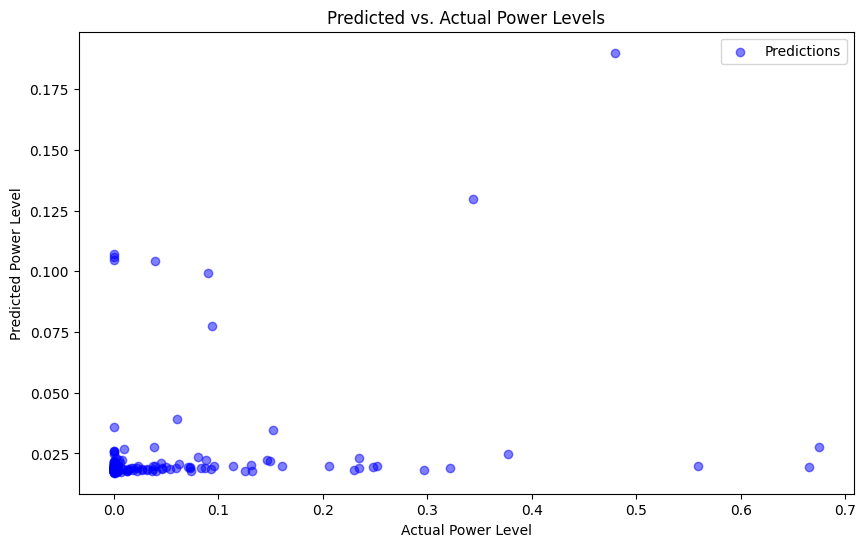

Best hyperparameters: [9.256818992066895e-05, np.int64(1200), 0.08599404067363209]
Best validation MAE: 0.04400685429573059
Training final model with the best hyperparameters...


<ipython-input-21-2a7ed30193fa>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df[usecols].apply(combine_features, axis=1)
<ipython-input-21-2a7ed30193fa>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text'] = test_df[usecols].apply(combine_features, axis=1)


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-21-2a7ed30193fa>:98: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Epoch,Training Loss,Validation Loss,Mae
1,0.172500,0.054917,0.226762
2,0.006400,0.009313,0.052636
3,0.011600,0.008937,0.062708
4,0.009800,0.008668,0.068335
5,0.012200,0.008922,0.063731


{'eval_loss': 0.009312557056546211, 'eval_mae': 0.05263550579547882, 'eval_runtime': 5.9214, 'eval_samples_per_second': 37.491, 'eval_steps_per_second': 4.729, 'epoch': 5.0}
Top 10 Highest Predicted Values:
--------------------------------------------------
Name: Switch, Predicted: 0.0426, Actual: 0.0936
Name: Great Ball, Predicted: 0.0412, Actual: 0.0096
Name: Shopping Center, Predicted: 0.0407, Actual: 0.0000
Name: Skaters' Park, Predicted: 0.0395, Actual: 0.0018
Name: Gapejaw Bog, Predicted: 0.0391, Actual: 0.0006
Name: Temple of Sinnoh, Predicted: 0.0388, Actual: 0.0383
Name: Lake Acuity, Predicted: 0.0382, Actual: 0.0000
Name: Crystal Cave, Predicted: 0.0380, Actual: 0.0053
Name: Crushing Hammer, Predicted: 0.0366, Actual: 0.0022
Name: Defiance Band, Predicted: 0.0364, Actual: 0.0028

Top 10 Highest Actual Values:
--------------------------------------------------
Name: Ultra Ball, Actual: 0.6744, Predicted: 0.0340
Name: Battle VIP Pass, Actual: 0.6656, Predicted: 0.0345
Name: Nes

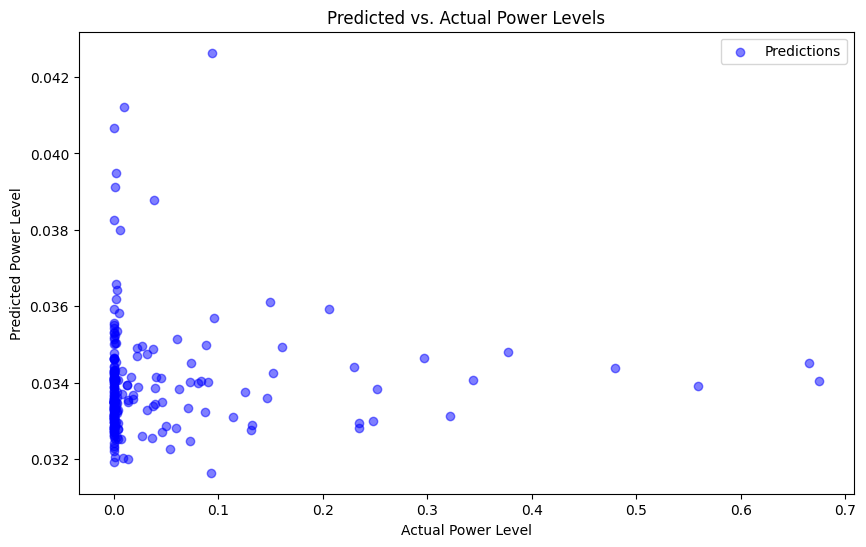

Saving the best model to /content/drive/MyDrive/266/project/trainerRobertaTuned


          fun: 0.04400685429573059
            x: [9.256818992066895e-05, np.int64(1200), 0.08599404067363209]
    func_vals: [ 5.400e-02  5.681e-02  5.674e-02  4.967e-02  4.809e-02
                 5.800e-02  5.747e-02  6.341e-02  6.159e-02  4.401e-02]
      x_iters: [[3.918194347141745e-05, np.int64(775), 0.07796910002727696], [1.5620693675639854e-05, np.int64(1169), 0.009997491581800293], [8.288916866885136e-06, np.int64(1001), 0.014286681792194082], [2.0034427927560742e-05, np.int64(585), 0.07219987722668249], [7.535384509295558e-05, np.int64(501), 0.09922115592912178], [1.7177621112338382e-05, np.int64(1417), 0.0007066305219717408], [1.112051371571063e-06, np.int64(1287), 0.03998609717152556], [1.2397420340784145e-06, np.int64(1961), 0.02327713404303043], [1.5177941306507508e-06, np.int64(1428), 0.038246199126716285], [9.256818992066895e-05, np.int64(1200), 0.08599404067363209]]
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1], nu=2.5) + WhiteKe

In [ ]:
# Trainer Roberta Fine Tuned Model Saved
model_save_path = '/content/drive/MyDrive/266/project/trainerRobertaTuned'

trainer_concat = pd.concat([trainer_2021, trainer_2022], ignore_index=True)

train_and_evaluate_roberta_tuned_model(trainer_concat, trainer_2023, usecols, model_save_path)

In [ ]:
import optuna
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import mean_absolute_error

def train_and_evaluate_ensemble_model_advanced(train_df, test_df, usecols, model_save_path, n_trials=20, n_models=5):
    def combine_features(row):
        return ' '.join(row.values.astype(str))

    train_df['text'] = train_df[usecols].apply(combine_features, axis=1)
    test_df['text'] = test_df[usecols].apply(combine_features, axis=1)

    if 'power_level' in train_df.columns and 'power_level' in test_df.columns:
        train_df['power_level'] = np.log1p(train_df['power_level'])
        test_df['power_level'] = np.log1p(test_df['power_level'])
    else:
        raise ValueError("Column 'power_level' not found in train or test dataset")

    train_dataset = Dataset.from_pandas(train_df[['text', 'power_level']])
    test_dataset = Dataset.from_pandas(test_df[['text', 'power_level']])

    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

    def preprocess_function(examples):
        return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=512)

    train_dataset = train_dataset.map(preprocess_function, batched=True)
    test_dataset = test_dataset.map(preprocess_function, batched=True)

    train_dataset = train_dataset.rename_column("power_level", "labels")
    test_dataset = test_dataset.rename_column("power_level", "labels")

    train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

    class CustomTrainer(Trainer):
      def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits").squeeze()

        abs_error = torch.abs(logits - labels)
        weights = torch.where(abs_error < 0.1, 1.0, 2.0).to(logits.device)

        delta = 1.0
        loss = torch.where(abs_error <= delta, 0.5 * (abs_error ** 2), delta * (abs_error - 0.5 * delta))
        loss = loss * weights
        loss = loss.mean()

        return (loss, outputs) if return_outputs else loss

    # MAE Metric Function
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = logits.squeeze()
        return {"mae": mean_absolute_error(labels, predictions)}

    def objective(trial):
        learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-3)
        batch_size = trial.suggest_categorical('batch_size', [8])
        num_train_epochs = trial.suggest_int('num_train_epochs', 3, 5)
        warmup_steps = trial.suggest_int('warmup_steps', 200, 1000)
        model_type = trial.suggest_categorical('model_type', ['roberta', 'bert'])

        if model_type == 'roberta':
            model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=1)
        else:
            model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)

        training_args = TrainingArguments(
            output_dir='./outputResults',
            num_train_epochs=num_train_epochs,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            learning_rate=learning_rate,
            warmup_steps=warmup_steps,
            weight_decay=0.01,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            report_to=None,
            metric_for_best_model="mae",
            greater_is_better=False,
        )

        trainer = CustomTrainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics,
        )
        trainer.train()
        eval_results = trainer.evaluate()
        return eval_results["eval_mae"]

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    best_params = study.best_params
    models = []

    for _ in range(n_models):
        model_type = best_params['model_type']
        if model_type == 'roberta':
            model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=1)
        else:
            model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)

        training_args = TrainingArguments(
            output_dir='./outputResults',
            num_train_epochs=best_params['num_train_epochs'],
            per_device_train_batch_size=best_params['batch_size'],
            per_device_eval_batch_size=best_params['batch_size'],
            learning_rate=best_params['learning_rate'],
            warmup_steps=best_params['warmup_steps'],
            weight_decay=0.01,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            report_to=None,
            metric_for_best_model="mae",
            greater_is_better=False,
        )

        trainer = CustomTrainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics,
        )
        trainer.train()
        models.append(model)

    def ensemble_predictions(models, dataset):
        all_predictions = []
        for model in models:
            trainer = Trainer(
                model=model,
                tokenizer=tokenizer,
                compute_metrics=compute_metrics
            )
            predictions = trainer.predict(dataset)
            all_predictions.append(predictions.predictions.squeeze())
        return np.mean(all_predictions, axis=0)

    predictions = ensemble_predictions(models, test_dataset)
    predicted_values = np.expm1(predictions)
    actual_values = np.expm1(test_dataset['labels'].numpy())

    print_top_10_predictions(predicted_values, actual_values, test_df)

    print("Ensemble MAE:", mean_absolute_error(actual_values, predicted_values))

    plt.figure(figsize=(10, 6))
    plt.scatter(actual_values, predicted_values, alpha=0.5, c='blue', label='Predictions')
    plt.xlabel('Actual Power Level')
    plt.ylabel('Predicted Power Level')
    plt.title('Ensemble Predictions vs Actual')
    plt.legend()
    plt.show()

    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)
    for i, model in enumerate(models):
        model.save_pretrained(f'{model_save_path}/model_{i}')
        tokenizer.save_pretrained(f'{model_save_path}/model_{i}')

In [ ]:
# Pokemon Ensemble Model
model_save_path = '/content/drive/MyDrive/266/project/pokemonEnsemble'

pokemon_concat = pd.concat([pokemon_2021, pokemon_2022], ignore_index=True)

train_and_evaluate_ensemble_model_advanced(pokemon_concat, pokemon_2023, usecols, model_save_path)

In [ ]:
# Trainer Ensemble Model
model_save_path = '/content/drive/MyDrive/266/project/trainerEnsemble'

trainer_concat = pd.concat([trainer_2021, trainer_2022], ignore_index=True)

train_and_evaluate_ensemble_model_advanced(trainer_concat, trainer_2023, usecols, model_save_path)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/278 [00:00<?, ? examples/s]

Map:   0%|          | 0/192 [00:00<?, ? examples/s]

[I 2025-04-05 05:07:21,577] A new study created in memory with name: no-name-6d6aa451-42aa-4ba1-abad-77cc40c0a6bc
<ipython-input-4-fa7c317b1fb4>:71: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-3)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-4-fa7c317b1fb4>:98: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Epoch,Training Loss,Validation Loss


In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

def train_and_evaluate_mlp_model(train_df, test_df, usecols, model_save_path):
    X_train = train_df[usecols]
    y_train = train_df['power_level']
    X_test = test_df[usecols]
    y_test = test_df['power_level']

    categorical_columns = X_train.select_dtypes(include=['object']).columns
    numerical_columns = X_train.select_dtypes(exclude=['object']).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
            ('num', StandardScaler(), numerical_columns)
        ],
        remainder='passthrough'
    )

    mlp = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', MLPRegressor())
    ])

    param_grid = {
        'regressor__hidden_layer_sizes': [(50,), (100,), (100, 50), (200,)],
        'regressor__activation': ['relu', 'tanh'],
        'regressor__solver': ['adam'],
        'regressor__learning_rate': ['constant', 'adaptive'],
        'regressor__max_iter': [500, 1000, 1500]
    }

    grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print(f"Best parameters found: {grid_search.best_params_}")


    best_mlp = grid_search.best_estimator_

    predictions = best_mlp.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    print(f"Mean Absolute Error: {mae}")

    predictions = np.expm1(predictions)
    y_test = np.expm1(y_test)

    print_top_10_predictions(predictions, y_test, test_df)

    def plot_predictions(predictions, actual_values):
        plt.figure(figsize=(10, 6))
        plt.scatter(actual_values, predictions, alpha=0.5, c='blue', label='Predictions')
        plt.xlabel('Actual Power Level')
        plt.ylabel('Predicted Power Level')
        plt.title('Predicted vs. Actual Power Levels')
        plt.legend()
        plt.show()

    plot_predictions(predictions, y_test)

    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)

    model_filename = os.path.join(model_save_path, 'mlp_model.pkl')
    joblib.dump(best_mlp, model_filename)
    print(f"Model saved to {model_filename}")


Best parameters found: {'regressor__activation': 'tanh', 'regressor__hidden_layer_sizes': (100, 50), 'regressor__learning_rate': 'constant', 'regressor__max_iter': 500, 'regressor__solver': 'adam'}
Mean Absolute Error: 0.02449780276670642
Top 10 Highest Predicted Values:
--------------------------------------------------
Name: Genesect V, Predicted: 0.1476, Actual: 0.1413
Name: Mew V, Predicted: 0.1417, Actual: 0.1381
Name: Mew VMAX, Predicted: 0.1002, Actual: 0.1032
Name: Sobble, Predicted: 0.0985, Actual: 0.0000
Name: Pumpkaboo, Predicted: 0.0837, Actual: 0.0271
Name: Dunsparce, Predicted: 0.0583, Actual: 0.0022
Name: Stoutland V, Predicted: 0.0548, Actual: 0.0000
Name: Wailord, Predicted: 0.0473, Actual: 0.0000
Name: Duraludon VMAX, Predicted: 0.0328, Actual: 0.0243
Name: Venusaur, Predicted: 0.0323, Actual: 0.0000

Top 10 Highest Actual Values:
--------------------------------------------------
Name: Comfey, Actual: 0.3325, Predicted: -0.0321
Name: Archeops, Actual: 0.1607, Predict

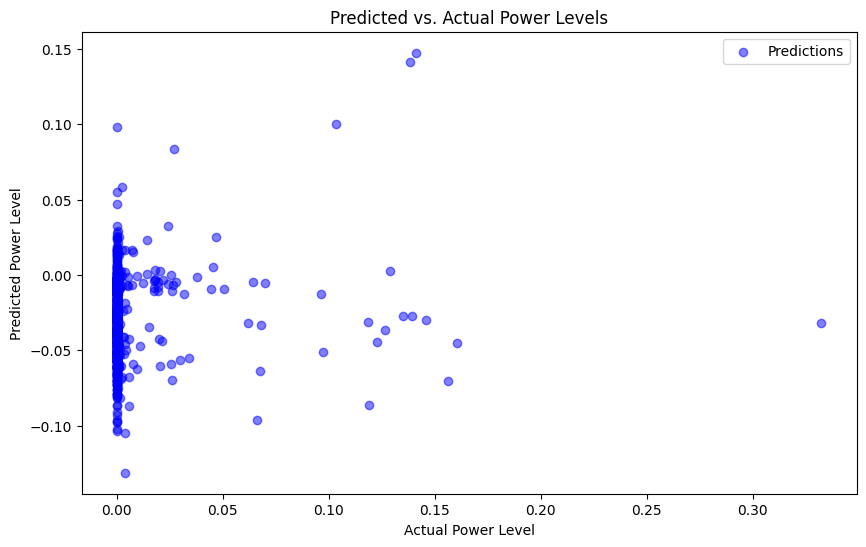

Model saved to /content/drive/MyDrive/266/project/pokemonMLP/mlp_model.pkl


In [ ]:
# Pokemon MLP Model
model_save_path = '/content/drive/MyDrive/266/project/pokemonMLP'

pokemon_concat = pd.concat([pokemon_2021, pokemon_2022], ignore_index=True)

train_and_evaluate_mlp_model(pokemon_concat, pokemon_2023, usecols, model_save_path)

Best parameters found: {'regressor__activation': 'tanh', 'regressor__hidden_layer_sizes': (100,), 'regressor__learning_rate': 'constant', 'regressor__max_iter': 500, 'regressor__solver': 'adam'}
Mean Absolute Error: 0.05199117684122285
Top 10 Highest Predicted Values:
--------------------------------------------------
Name: Boss's Orders, Predicted: 0.4743, Actual: 0.6158
Name: Switch, Predicted: 0.4220, Actual: 0.0981
Name: Professor's Research, Predicted: 0.4187, Actual: 0.4100
Name: Battle VIP Pass, Predicted: 0.4106, Actual: 0.9457
Name: Escape Rope, Predicted: 0.2364, Actual: 0.4584
Name: Path to the Peak, Predicted: 0.1855, Actual: 0.2286
Name: Energy Search, Predicted: 0.1428, Actual: 0.0072
Name: Power Tablet, Predicted: 0.1260, Actual: 0.1413
Name: Egg Incubator, Predicted: 0.1184, Actual: 0.0000
Name: Lure Module, Predicted: 0.1184, Actual: 0.0000

Top 10 Highest Actual Values:
--------------------------------------------------
Name: Ultra Ball, Actual: 0.9628, Predicted: 0.1

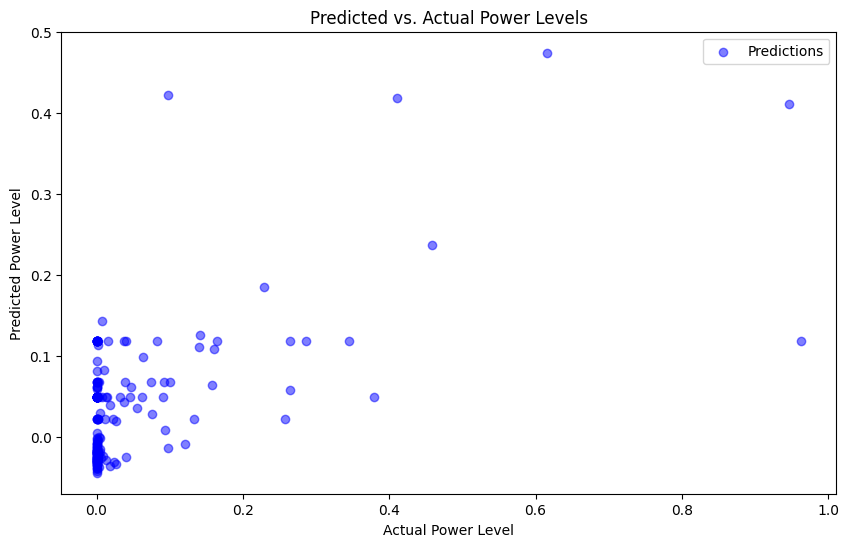

Model saved to /content/drive/MyDrive/266/project/trainerMLP/mlp_model.pkl


In [ ]:
# Trainer MLP Model
model_save_path = '/content/drive/MyDrive/266/project/trainerMLP'

trainer_concat = pd.concat([trainer_2021, trainer_2022], ignore_index=True)

train_and_evaluate_mlp_model(trainer_concat, trainer_2023, usecols, model_save_path)

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

def train_and_evaluate_svr_model(train_df, test_df, usecols, model_save_path):
    X_train = train_df[usecols]
    y_train = train_df['power_level']
    X_test = test_df[usecols]
    y_test = test_df['power_level']

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), usecols)
        ],
        remainder='passthrough'
    )

    svr = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', SVR())
    ])

    param_grid = {
        'regressor__C': [1, 10, 100],
        'regressor__epsilon': [0.1, 0.2, 0.5],
        'regressor__kernel': ['linear', 'rbf']
    }

    grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print(f"Best parameters: {grid_search.best_params_}")

    best_svr = grid_search.best_estimator_
    test_predictions = best_svr.predict(X_test)

    mae = mean_absolute_error(y_test, test_predictions)
    print(f"Test MAE: {mae}")

    print_top_10_predictions(test_predictions, y_test, test_df)

    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, test_predictions, alpha=0.5, c='blue', label='Predictions')
    plt.xlabel('Actual Power Level')
    plt.ylabel('Predicted Power Level')
    plt.title('Predicted vs. Actual Power Levels')
    plt.legend()
    plt.show()

    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)

    model_filename = os.path.join(model_save_path, 'svr_model.pkl')
    joblib.dump(best_svr, model_filename)
    print(f"Model saved to {model_filename}")

Best parameters: {'regressor__C': 1, 'regressor__epsilon': 0.1, 'regressor__kernel': 'linear'}
Test MAE: 0.06225867888941549
Top 10 Highest Predicted Values:
--------------------------------------------------
Name: Radiant Hisuian Sneasler, Predicted: 0.0929, Actual: 0.0000
Name: Liepard V, Predicted: 0.0927, Actual: 0.0000
Name: Honchkrow V, Predicted: 0.0926, Actual: 0.0000
Name: Jirachi V, Predicted: 0.0904, Actual: 0.0000
Name: Qwilfish, Predicted: 0.0899, Actual: 0.0000
Name: Raikou V, Predicted: 0.0899, Actual: 0.0601
Name: Rotom V, Predicted: 0.0899, Actual: 0.0017
Name: Drapion V, Predicted: 0.0890, Actual: 0.0658
Name: Kricketune V, Predicted: 0.0881, Actual: 0.0004
Name: Galarian Moltres V, Predicted: 0.0879, Actual: 0.0012

Top 10 Highest Actual Values:
--------------------------------------------------
Name: Comfey, Actual: 0.2870, Predicted: 0.0724
Name: Archeops, Actual: 0.1490, Predicted: 0.0696
Name: Lugia V, Actual: 0.1453, Predicted: 0.0698
Name: Kirlia, Actual: 0.136

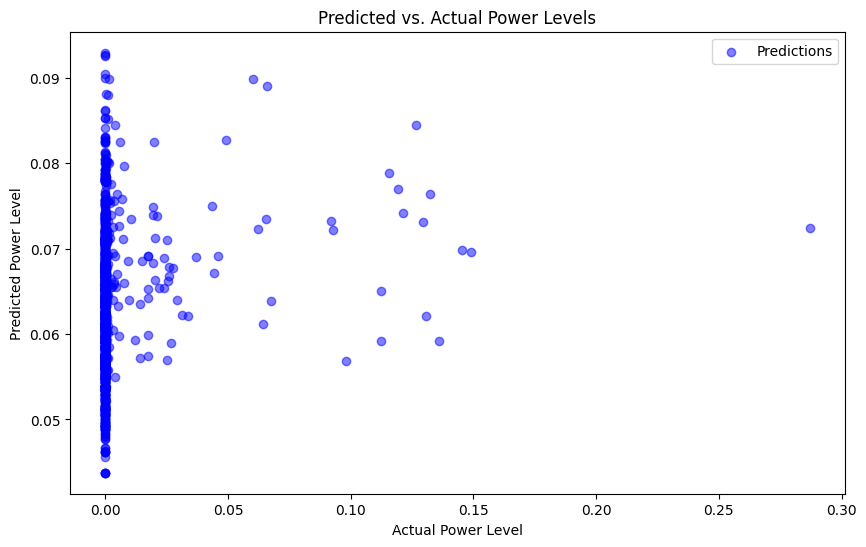

Model saved to /content/drive/MyDrive/266/project/pokemonSVR/svr_model.pkl


In [ ]:
# Pokemon SVR Model
model_save_path = '/content/drive/MyDrive/266/project/pokemonSVR'

pokemon_concat = pd.concat([pokemon_2021, pokemon_2022], ignore_index=True)

train_and_evaluate_svr_model(pokemon_concat, pokemon_2023, usecols, model_save_path)

Best parameters: {'regressor__C': 1, 'regressor__epsilon': 0.1, 'regressor__kernel': 'linear'}
Test MAE: 0.11289055751338543
Top 10 Highest Predicted Values:
--------------------------------------------------
Name: Boss's Orders, Predicted: 0.3967, Actual: 0.4798
Name: Professor's Research, Predicted: 0.3542, Actual: 0.3436
Name: Battle VIP Pass, Predicted: 0.2904, Actual: 0.6656
Name: Switch, Predicted: 0.2151, Actual: 0.0936
Name: Escape Rope, Predicted: 0.1599, Actual: 0.3773
Name: Cram-o-matic, Predicted: 0.1496, Actual: 0.1307
Name: Fog Crystal, Predicted: 0.1496, Actual: 0.1141
Name: Level Ball, Predicted: 0.1496, Actual: 0.1461
Name: Energy Recycler, Predicted: 0.1496, Actual: 0.0729
Name: Boost Shake, Predicted: 0.1417, Actual: 0.0000

Top 10 Highest Actual Values:
--------------------------------------------------
Name: Ultra Ball, Actual: 0.6744, Predicted: 0.1337
Name: Battle VIP Pass, Actual: 0.6656, Predicted: 0.2904
Name: Boss's Orders, Actual: 0.4798, Predicted: 0.3967
N

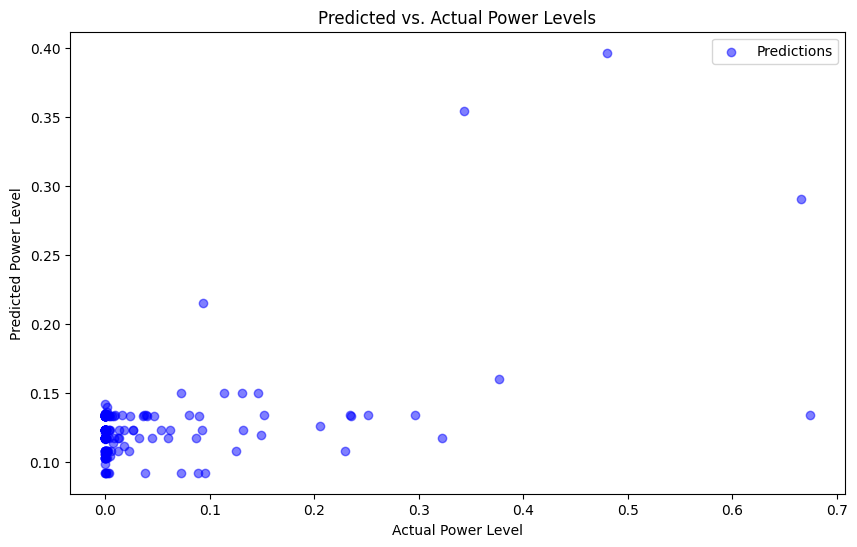

Model saved to /content/drive/MyDrive/266/project/trainerSVR/svr_model.pkl


In [ ]:
# Trainer SVR Model 2
model_save_path = '/content/drive/MyDrive/266/project/trainerSVR'

trainer_concat = pd.concat([trainer_2021, trainer_2022], ignore_index=True)

train_and_evaluate_svr_model(trainer_concat, trainer_2023, usecols, model_save_path)